In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
from mpl_toolkits import mplot3d

In [2]:
%config InlineBackend.figure_format = 'retina'   ##QUALITY FIGURES!!

## Degrees in Telecommunication Engineering, group 95M
## Modern Theory of Detection and Estimation
### Fall 2022

&nbsp;
&nbsp;
&nbsp;
# Linear Regression

&nbsp;
&nbsp;
&nbsp;

**Emilio Parrado Hernández**

Dept. of Signal Processing and Communications

&nbsp;
&nbsp;
&nbsp;




<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />



# Regression problems

## Regression general scenario

- Given a set of **observations** with their corresponding **true target**, learn a **mathematical function** that **maps observations and targets**.

- **Inference:** use the learnt map to **estimate** the corresponding **target** for new data (**test observations**)

- Assess the goodness of the function in terms of the quality of the estimations with test data

## Differences between anaytical estimation and regression

Consider the following **toy problem**: somebody gives you the **height** of a person and you have to guess the **length of her/his left foot**.

| Observation (X)     |Target (S)| 
| :---        |    :----   | 
| Height (cm)      | Left foot length (cm)| 

###  Both approaches share the "inference" part

You will get some inputs (heights in cm) and you will need to provide with estimations of the feet length. For instance 

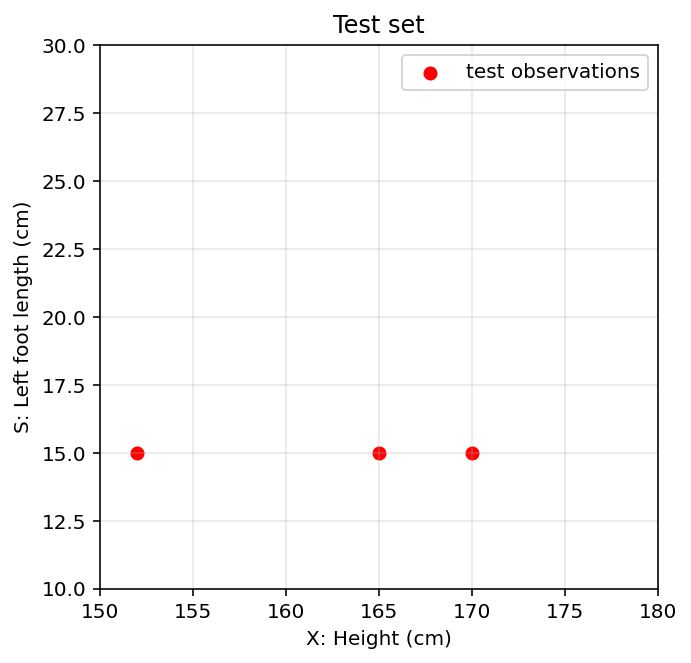

In [63]:
my_figsize = (5,5)
x_test = np.array([152, 165, 170])
plt.figure(figsize=my_figsize)
plt.scatter(x_test, 15*np.ones(3), marker='o', color='red', label='test observations')
plt.title('Test set')
plt.xlabel('X: Height (cm)')
plt.ylabel('S: Left foot length (cm)')
plt.grid(alpha=0.3)
plt.xlim((150,180))
plt.ylim((10,30))
_=plt.legend()

### Problem definition: analytic estimation

In the analytic estimation case one gets the problem defined in terms of the joint pdf of targets and observations: $p_{S,X}(S,X)$. 

For the above problem let's assume we know 

$$
p_{X,S}(x,s) \sim \mathcal N\left(\left [\begin{array}{c}x\\s\end{array}\right]|\left [\begin{array}{c}163\\23\end{array}\right] , \left [\begin{array}{cc} 57  & 11.5\\11.5& 4.6\end{array}\right]\right) 
$$

That is, $p_{X,S}(x,s)$ is Gaussian with:
- mean 
$$
\mathbf m_{X,S} = \left [\begin{array}{c}163\\23\end{array}\right] 
$$ and
- covariance matrix 
$$
\Sigma_{X,S} = \left [\begin{array}{cc}57 & 11.5\\11.5& 4.6\end{array}\right]
$$

In [4]:
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D 
def draw_Gauss_2d(ax, xmin=-1, xmax=1, ymin=-1, ymax=1, m=np.zeros(2), S=np.eye(2)):
  npoints=100
  Xg = np.linspace(xmin-.05*np.absolute(xmin),
                   xmax + .05*np.absolute(xmax),
                   npoints) # or whatever values for x
    
  Yg = np.linspace(ymin-.05*np.absolute(ymin),
                   ymax + .05*np.absolute(ymax),
                   npoints)   # or whatever values for y
  X, Y = np.meshgrid(Xg, Yg)
  Xshape = X.shape
    
  x_test = np.hstack((X.reshape(-1,1), Y.reshape(-1,1)))
  rv = multivariate_normal(m, S)
  zz = rv.pdf(x_test)
  zz = zz.reshape(Xshape)
  return ax.contourf(X, Y, zz, alpha=0.2, cmap='PuOr')

def draw_Gauss_3d(ax, xmin=-1, xmax=1, ymin=-1, ymax=1, m=np.zeros(2), S=np.eye(2)):
  npoints=100
  Xg = np.linspace(xmin-.05*np.absolute(xmin),
                   xmax + .05*np.absolute(xmax),
                   npoints) # or whatever values for x
    
  Yg = np.linspace(ymin-.05*np.absolute(ymin),
                   ymax + .05*np.absolute(ymax),
                   npoints)   # or whatever values for y
  X, Y = np.meshgrid(Xg, Yg)
  Xshape = X.shape
    
  x_test = np.hstack((X.reshape(-1,1), Y.reshape(-1,1)))
  rv = multivariate_normal(m, S)
  zz = rv.pdf(x_test)
  zz = zz.reshape(Xshape)
  return ax.plot_surface(X, Y, zz, cmap='PuOr',
                       linewidth=0, antialiased=False)

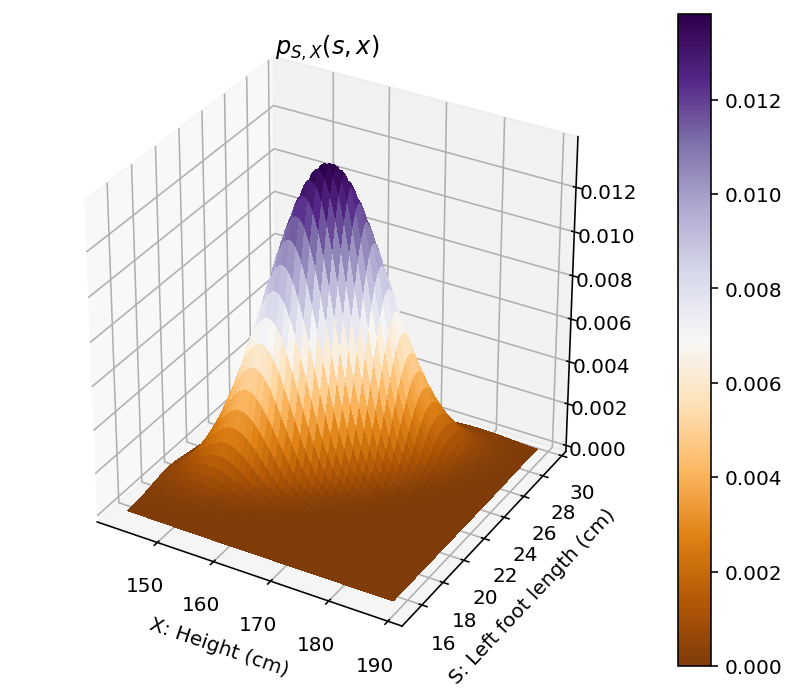

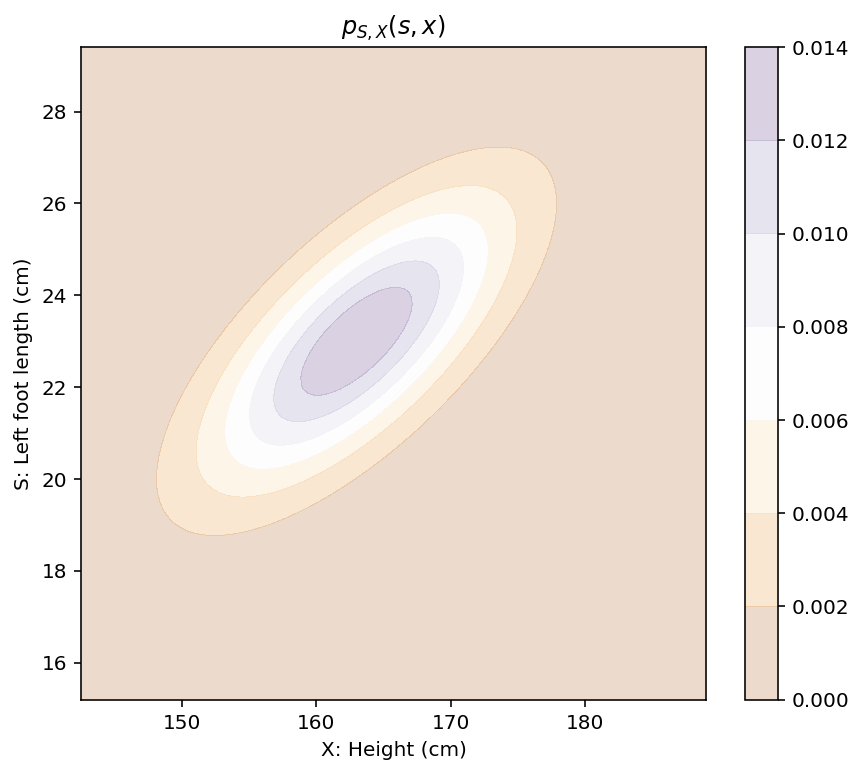

In [5]:
m_sx = np.array([163,23])
S_sx = np.array([[57, 11.5],[11.5,4.6]])
 
fig = plt.figure(figsize=(7,6))
aa = fig.add_subplot(111, projection='3d')

hh = draw_Gauss_3d(aa, 150,180,16,28,m_sx, S_sx)
fig.colorbar(hh,ax=aa)
aa.set_xlabel('X: Height (cm)')
aa.set_ylabel('S: Left foot length (cm)')
aa.set_title('$p_{S,X}(s,x)$')

ff,aa = plt.subplots(1,1,figsize=(7,6))
hh = draw_Gauss_2d(aa, 150,180,16,28,m_sx, S_sx)
ff.colorbar(hh,ax=aa)
aa.set_xlabel('X: Height (cm)')
aa.set_ylabel('S: Left foot length (cm)')
_=aa.set_title('$p_{S,X}(s,x)$')


### Problem definition: regression

In the **regression** case one gets the problem defined in terms of a collection of $N$ example pairs input/output $\{(x_i, y_i)\}_{i=1}^N$. In each pair $x_i$ is the height in cm and $y_i$ the length of the left foot in cm of subject $i$.

In [6]:

x_train = np.array([155., 154., 157., 161., 159., 157., 161., 166., 167., 169., 174.,
       174., 168., 165., 160., 153., 175., 175., 175., 170., 157., 159.,
       159., 152., 160.])

y_train = np.array([21.2, 20.8, 21. , 21.3, 22.2, 23.3, 23.9, 24.6, 24. , 23.7, 25. ,
       26. , 25.9, 24.7, 22.7, 22.6, 23.3, 25. , 26.1, 25.4, 25.6, 21.7,
       20. , 19. , 19.5])
y_test = np.array([16, 19, 22.5])

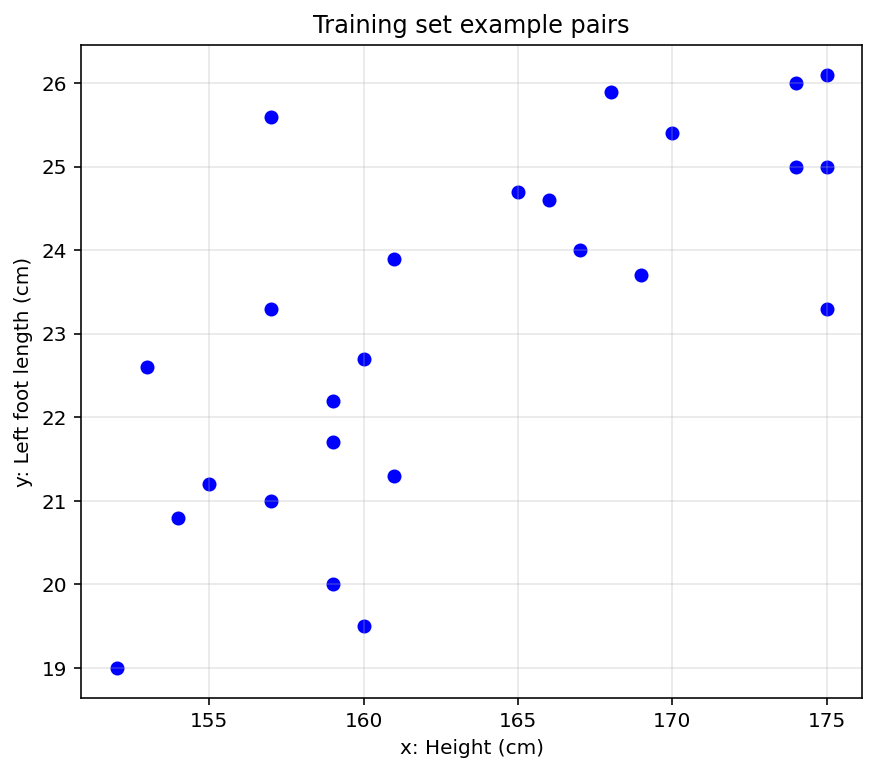

In [7]:
ff,aa = plt.subplots(1,1,figsize=(7,6))
aa.scatter(x_train, y_train, marker='o', color='blue', label='training set')
aa.set_xlabel('x: Height (cm)')
aa.set_ylabel('y: Left foot length (cm)')
aa.set_title('Training set example pairs')
aa.grid(alpha=0.3)
plt.savefig('height_foot_1.png')

### Putting all together

Depending on how is the problem defined, you will be using a different family of techniques (analytic estimation or regression) to solve it. 

Today we focus on **regression**.


(17.0, 27.0)

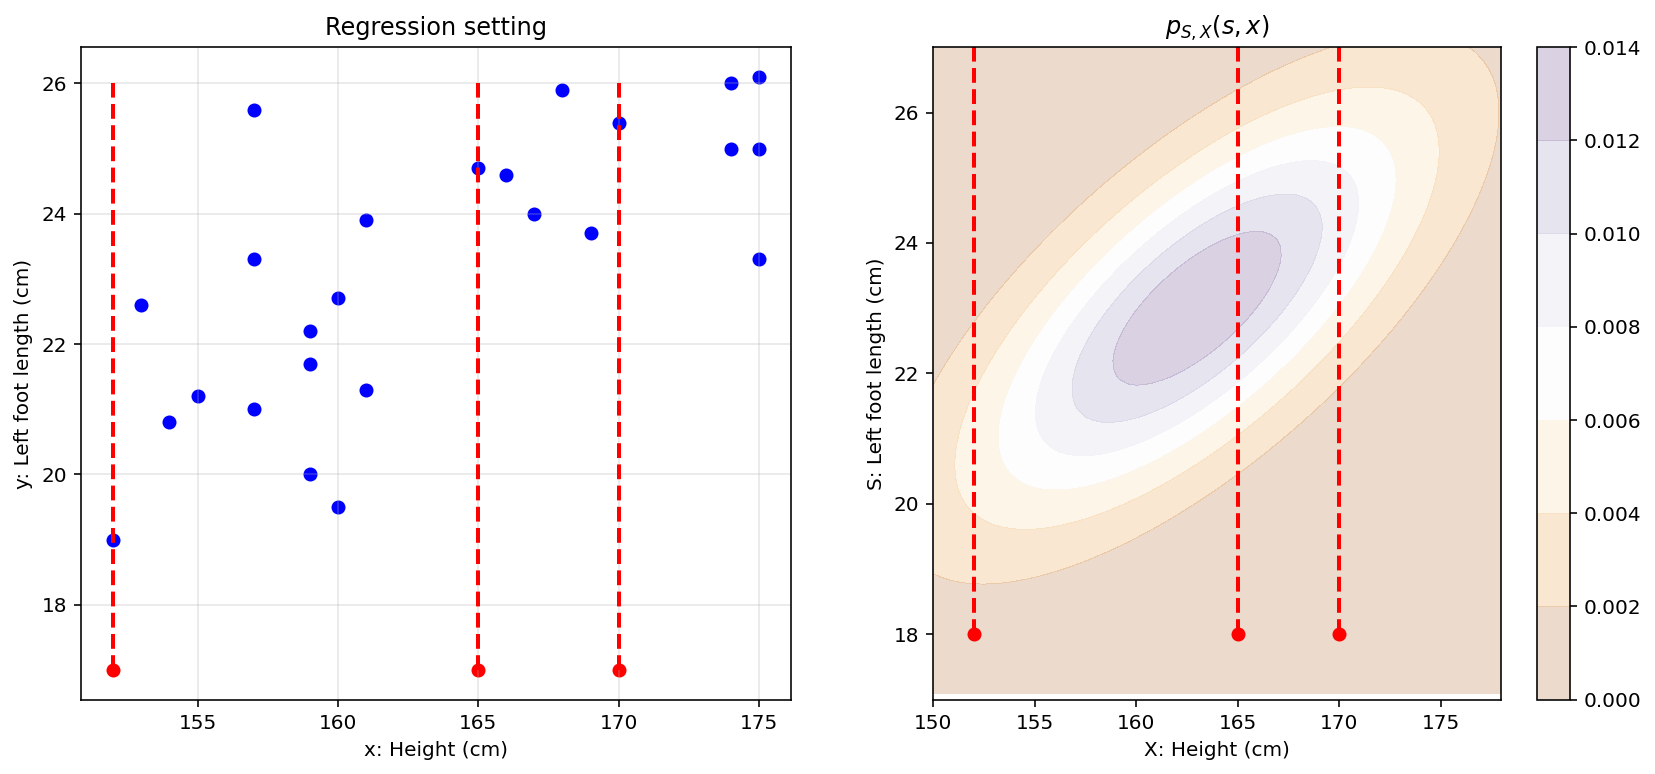

In [8]:
ff,aa = plt.subplots(1,2,figsize=(14,6))
aa[0].scatter(x_train, y_train, marker='o', color='blue', label='training set')
aa[0].set_xlabel('x: Height (cm)')
aa[0].set_ylabel('y: Left foot length (cm)')
aa[0].set_title('Regression setting')
aa[0].grid(alpha=0.3)
aa[0].scatter(x_test, 17*np.ones(3), marker='o', color='red', label='test observations')
for ii, xt in enumerate(x_test): 
    aa[0].plot([xt,xt],[17,26], linestyle='--', linewidth=2, color='red')

hh = draw_Gauss_2d(aa[1], 150,175,18,28,m_sx, S_sx)
ff.colorbar(hh,ax=aa[1])
aa[1].set_xlabel('X: Height (cm)')
aa[1].set_ylabel('S: Left foot length (cm)')
aa[1].set_title('$p_{S,X}(s,x)$')
aa[1].scatter(x_test, 18*np.ones(3), marker='o', color='red', label='test observations')
for ii, xt in enumerate(x_test): 
    aa[1].plot([xt,xt],[18,28], linestyle='--', linewidth=2, color='red')
aa[1].set_xlim((150,178))
aa[1].set_ylim((17,27))


### An even "Toy-er" problem

In order to gain insights about how a regression model is constructed, we will work with a reduced version of the height-foot problem including just three example training pairs.



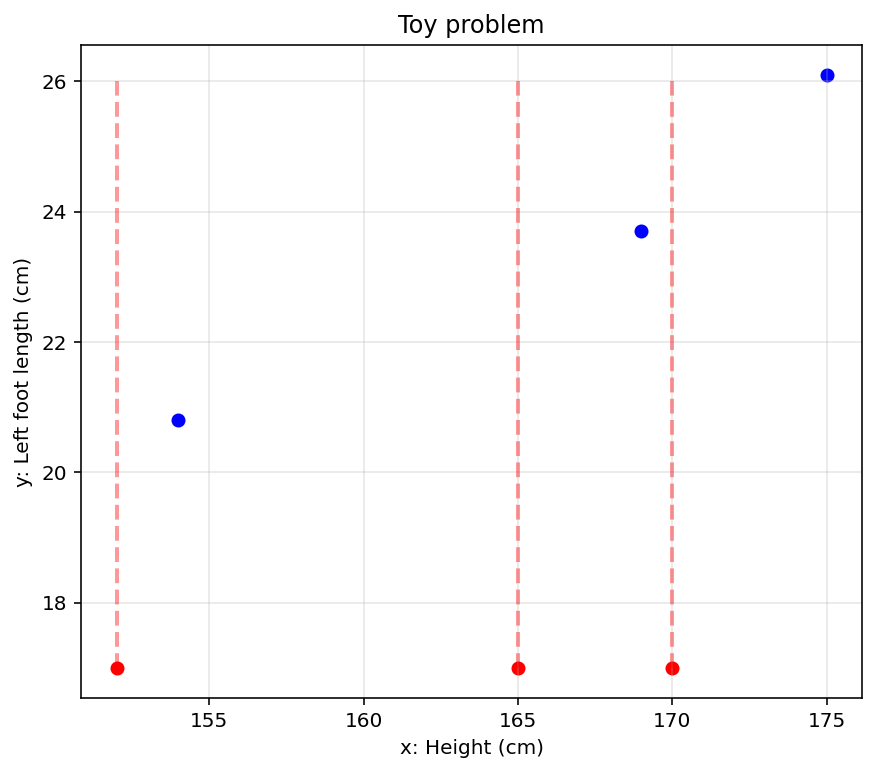

In [9]:
x_toy = x_train[[1, 9, 18]]
y_toy = y_train[[1, 9, 18]]

ff,aa = plt.subplots(1,1,figsize=(7,6))
aa.scatter(x_toy, y_toy, marker='o', color='blue', label='training set')
aa.set_xlabel('x: Height (cm)')
aa.set_ylabel('y: Left foot length (cm)')
aa.set_title('Toy problem')
aa.grid(alpha=0.3)
aa.scatter(x_test, 17*np.ones(3), marker='o', color='red', label='test observations')
for ii, xt in enumerate(x_test): 
    aa.plot([xt,xt],[17,26], linestyle='--', linewidth=2, color='red', alpha=0.4)

#### Toy problem solution with regression

- Learn solving an easy problem
- Abstract to more sophisticate situations
- Process: 
    - Fit a **linear regressor** to the three data
    - Learn how to **extend the model** to more data 

## Regression: It's all about the **model**

The main difference to move from the analytic estimation setting to the regression one is that:

**In estimation the focus is the estimator $\hat S$**. The estimator is a **random variable** that depends on the observation $\mathbf X$: 
$$
\hat S(\mathbf X)
$$

$\hat S(\mathbf X)$ is the value of $S$ that we will infer when we get observation $\mathbf X$.

### In regression the focus is the model $f()$

We **assume** there exists a mapping 
$$
s = f(\mathbf x)
$$

and our task is to find **function** $f()$. 

The usual setting is to follow these steps:

1. Choose a **familiy** of models. These models are usually parametric. Remember the **Estimators with constraints** part of the lectures

2. Choose a **criterion** to decide which member of the family of models serves best as a solution to your situation. This step plays the role of the selecting a cost in analytic estimation. We usually call this criterion **loss function** or **penalty**, as it is what you pay for errors in the estimations. In general we will use the **average quadratic loss**.

3. Solve an optimization problem that finds the best **set of parameters**, that is, the best member of the family of models in the sense that minimizes the **loss function**.

## Linear regression to solve the toy problem

You **believe** the data generation process was the following

1. The data generator chose a particular set of weights $w_0$ and $w_1$

2. The data generator selected 3 particular values of the variable $x$ (height): $x^{(1)} = 154$, $x^{(2)} = 169$ and $x^{(3)} = 175$

3. The data generator used the model to produce
$$
\begin{array}{ll}
s_1 =& w_0 + w_1x^{(1)} \\
s_2 =& w_0 + w_1x^{(2)} \\
s_3 =& w_0 + w_1x^{(3)} \
\end{array}
$$

4. Somebody corrupted with noise the true targets. In general we consider additive zero mean Gaussian noise. The noise level is the variance of the noise pdf, $\sigma_n^2$
$$
\begin{array}{ll}
y_1 =& s_1 + \epsilon_1 =  20.8\\
y_2 =& s_2 + \epsilon_2 = 23.7\\
y_3 =& s_3 + \epsilon_3 =  26.1\\
\end{array}
$$

where $\epsilon_1, \epsilon_2$ and $\epsilon_3$ are independently drawn from $\mathcal N(0,\sigma_n^2)$

5. The pairs $(x^{(1)}, y_1)$, $(x^{(2)}, y_2)$, $(x^{(3)}, y_3)$ were sent to you

6. Somebody asked you for an estimation of the true target for test inputs $x^{(t1)} = 152$, $x^{(t2)} = 165$ 
and $x^{(t3)} = 170$

Since you **believe** the model is linear, you may try with different values for $w_0$ and $w_1$ to construct model $f(x)$ and check how do they do.

You select the average quadratic loss as measure of goodness.
$$
J(w_0, w_1) = \frac{1}{3}\left((f(x^{(1)})-y_1)^2 + (f(x^{(2)})-y_2)^2 + (f(x^{(3)})-y_3)^2\right)
$$
$$
 =\frac{1}{3}\left( \sum_{i=1}^3{(f(x^{(i)})-y_i)^2}\right) = \frac{1}{3}\left(\sum_{i=1}^3{(w_0 + w_1x^{(i)}-y_i)^2}\right)
$$

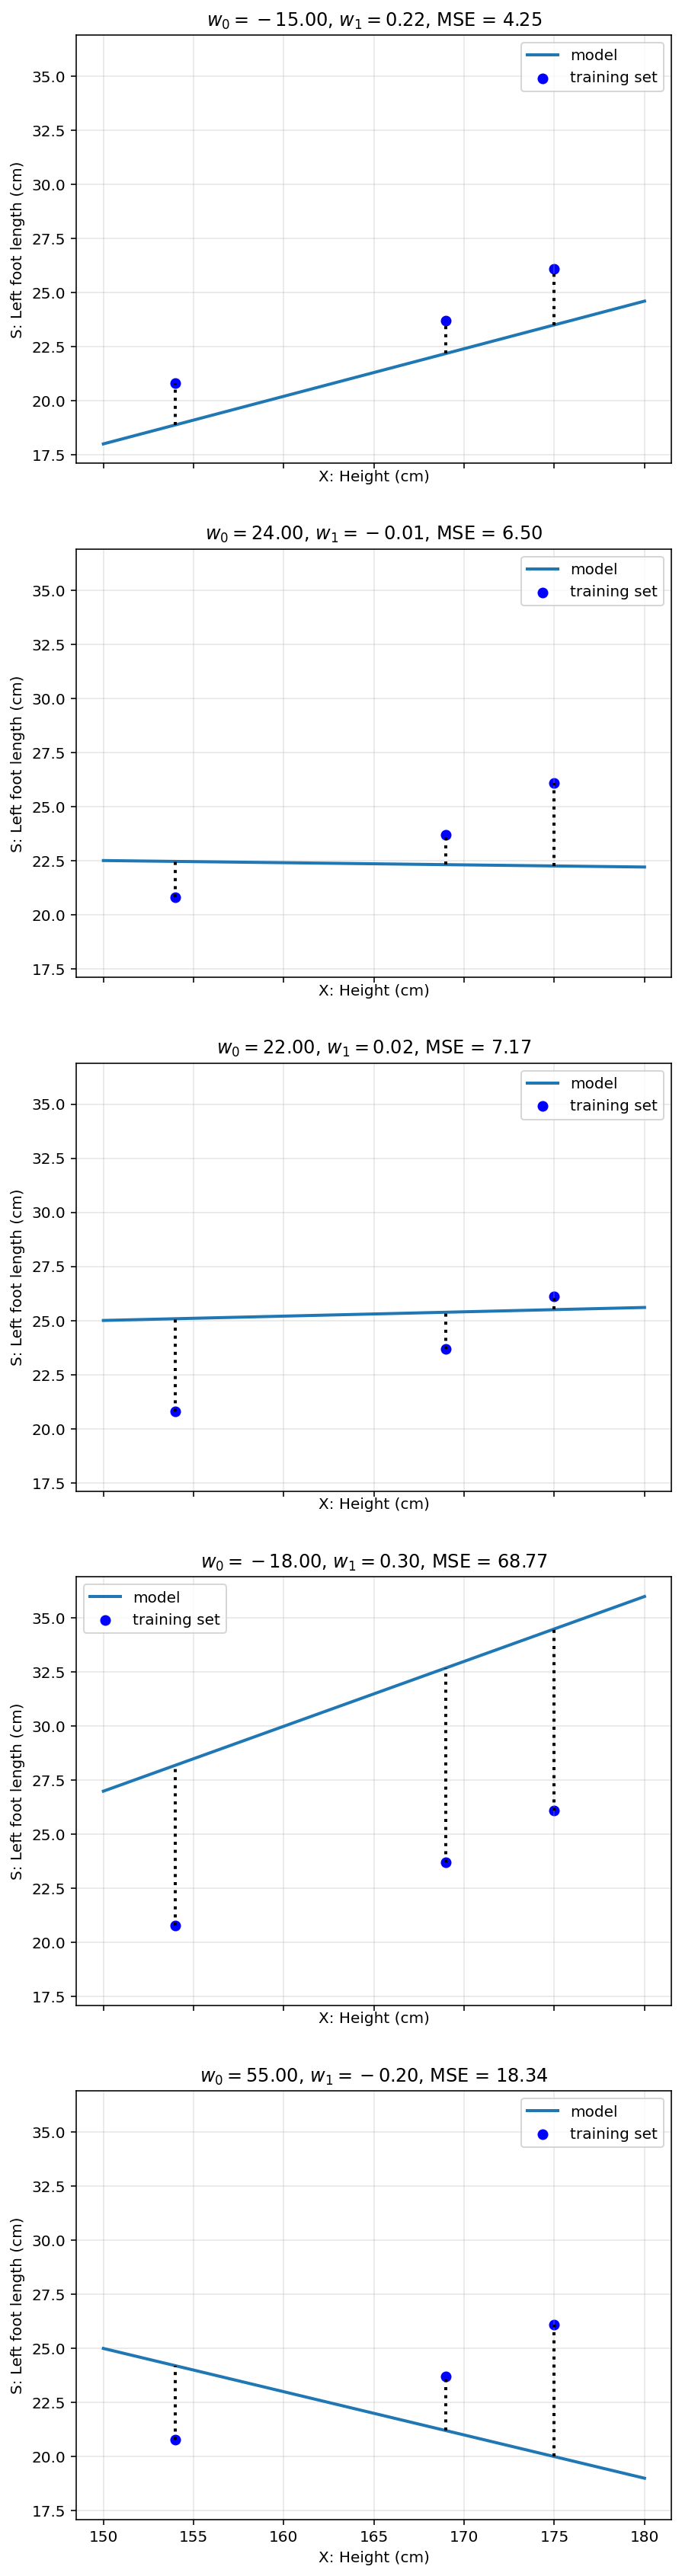

In [10]:
# Candidates for models. We evaluate 5 options for w0 and w1 (w0,w1)
v_w0 = np.array([-15, 24, 22, -18, 55])
v_w1 = np.array([0.22, -0.01, 0.02, 0.3, -0.2 ])

# initialize plots
nplots = len(v_w1)
ff,aa = plt.subplots(nplots,1,figsize=(7,6*nplots),sharex=True, sharey=True)

# loop for each candidate to model
for ii in range(nplots):
    # visualize training data
    aa[ii].scatter(x_toy, y_toy, marker='o', color='blue', label='training set')
    
    # instantiate model
    w_0 = v_w0[ii]
    w_1 = v_w1[ii]
    
    # evaluate model in training data s_toy has the predictions for the training observations
    s_toy = w_0 + x_toy * w_1
    
    # compute error in the estimations of training data
    mse = np.mean((s_toy - y_toy)**2)
    
    # compute data to draw line (a lot of points)
    xg = np.linspace(150,180,10)
    yg = w_0 + xg * w_1
    
    # plot line
    aa[ii].plot(xg,yg,linewidth=2,label='model')
    aa[ii].set_xlabel('X: Height (cm)')
    aa[ii].set_ylabel('S: Left foot length (cm)')
    aa[ii].set_title('$w_0 = {0:.2f}$, $w_1 = {1:.2f}$, MSE = {2:.2f}'.format(w_0, w_1, mse))
    aa[ii].grid(alpha=0.3)
    
    # plot error in training points
    for jj, xt in enumerate(x_toy):
        if s_toy[jj] > y_toy[jj]:
            y1 = y_toy[jj]
            y2 = s_toy[jj]
        else:
            y2 = y_toy[jj]
            y1 = s_toy[jj]
        aa[ii].plot([xt,xt],[y1,y2], linestyle=':', linewidth=2, color='black')
    aa[ii].legend()

### Least Squares

To try an infinite number of models to find the best one does not seem a good idea.

Write an **optimization** problem to find the best model.



$$
\min_{w_0, w_1} \frac{1}{3}\left(\sum_{i=1}^3{(w_0 + w_1x^{(i)}-y_i)^2}\right)
$$

#### Matrix notation
$$
w_0 + w_1x = \left[ \begin{array}{cc}1 & x \end{array} \right]\left[ \begin{array}{c}w_0 \\ w_1 \end{array} \right]
$$

The output to all the training observations can be represented in matrix form as as

$$
\left[ \begin{array}{cc}1 & x^{(1)} \\ 1 & x^{(2)} \\ 1 & x^{(3)} \end{array} \right]\left[ \begin{array}{c}w_0 \\ w_1 \end{array} \right] = \left[  \begin{array}{c}w_0 + w_1 x^{(1)} \\ w_0 + w_1 x^{(2)} \\w_0 + w_1 x^{(3)} \end{array} \right] 
$$

Now consider a vector with all the observed targets for the training observations:

$$
\mathbf y = \left[ \begin{array}{c}y_1 \\ y_2 \\ y_3 \end{array} \right]
$$

So the approximation error can be written in vector form as

$$
 \left[  \begin{array}{c}y_1 - w_0 - w_1 x^{(1)} \\y_2 -  w_0 - w_1 x^{(2)} \\y_3 - w_0 - w_1 x^{(3)} \end{array} \right] =   \left[ \begin{array}{c}y_1 \\ y_2 \\ y_3 \end{array} \right]-  \left[  \begin{array}{c}w_0 + w_1 x^{(1)} \\ w_0 + w_1 x^{(2)} \\w_0 + w_1 x^{(3)} \end{array} \right] = \left[ \begin{array}{c}y_1 \\ y_2 \\ y_3 \end{array} \right] - \left[ \begin{array}{cc}1 & x^{(1)} \\ 1 & x^{(2)} \\ 1 & x^{(3)} \end{array} \right]\left[ \begin{array}{c}w_0 \\ w_1 \end{array} \right] = \mathbf y - X\mathbf w
$$

And the sum of squares of the approximation errors can be calculated as
$$
\sum_{i=1}^3{(w_0 + w_1x^{(i)}-y_i)^2} = \left[  \begin{array}{ccc}y_1 - w_0 - w_1 x^{(1)} & y_2 -  w_0 - w_1 x^{(2)} & y_3 - w_0 - w_1 x^{(3)} \end{array} \right]^\top \left[  \begin{array}{c}y_1 - w_0 - w_1 x^{(1)} \\y_2 -  w_0 - w_1 x^{(2)} \\y_3 - w_0 - w_1 x^{(3)} \end{array} \right] =
$$

$$
=\left( \mathbf y - X\mathbf w\right)^\top \left( \mathbf y - X\mathbf w\right)
$$

Therefore the optimization problem can be casted into matrix form as

$$
\min_{\mathbf w} \left( \mathbf y - X\mathbf w\right)^\top \left( \mathbf y - X\mathbf w\right)
$$





#### Solution

Making the gradient with respect to $\mathbf w$ equal to $\mathbf 0$ yields

$$
\nabla_{\mathbf w} \left \{ \left( \mathbf y - X\mathbf w\right)^\top \left( \mathbf y - X\mathbf w\right)\right \} = \mathbf 0
$$

$$
\nabla_{\mathbf w} \left( \mathbf y^\top \mathbf y - 2 \mathbf w^\top  X^\top\mathbf y + \mathbf w^\top X^\top X\mathbf w\right) = \mathbf 0
$$

$$
- 2   X^\top \mathbf y+ 2 X^\top X\mathbf w = 0 
$$

Solving for $\mathbf w$ yields

$$
\mathbf w = (X^\top X)^{-1} X^\top \mathbf y
$$

In python:

In [11]:
# add a column of ones to the column with the X
Xe = np.vstack((np.ones(len(x_toy)), x_toy)).T

# compute x = inv(X.T * X) * X.T * y
w = np.linalg.inv(Xe.T.dot(Xe)).dot(Xe.T).dot(y_toy)

print('Solution: w_0 = {0:.2f}, w_1 = {1:.2f}'.format(w[0], w[1]))

Solution: w_0 = -16.48, w_1 = 0.24


#### Pseudo inverse

$$
(X^\top X)^{-1} X^\top 
$$ is called the **pseudoinverse** of $X$

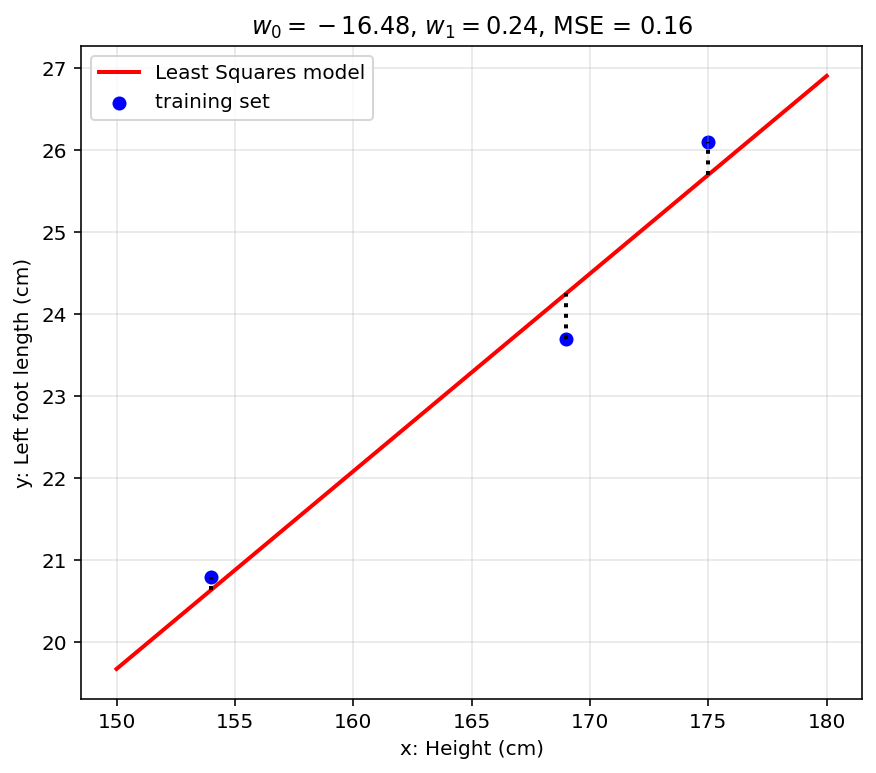

In [12]:
plt.figure(figsize=(7,6))
plt.scatter(x_toy, y_toy, marker='o', color='blue', label='training set')

# retrieve w0 and w1 obtained from the optimization
w_0 = w[0]
w_1 = w[1]

# predictions for training data
s_toy = w_0 + x_toy * w_1

# MSE of training data
mse = np.mean((s_toy - y_toy)**2)

# to plot the line
xg = np.linspace(150,180,10)
yg = w_0 + xg * w_1
plt.plot(xg,yg,linewidth=2,label='Least Squares model', color='red')
plt.xlabel('x: Height (cm)')
plt.ylabel('y: Left foot length (cm)')
plt.title('$w_0 = {0:.2f}$, $w_1 = {1:.2f}$, MSE = {2:.2f}'.format(w_0, w_1, mse))
plt.grid(alpha=0.3)

# plot error for each training data
for jj, xt in enumerate(x_toy):
    if s_toy[jj] > y_toy[jj]:
        y1 = y_toy[jj]
        y2 = s_toy[jj]
    else:
        y2 = y_toy[jj]
        y1 = s_toy[jj]
    plt.plot([xt,xt],[y1,y2], linestyle=':', linewidth=2, color='black')
_=plt.legend()

#### Estimation errors
| Observation ($x$)     |Observed target ($y$)| Estimation ($\hat s$) | Estimation Error $(y-\hat s)$ | Square Error ($(y-\hat s)^2$) | 
| :---        |    :----:   | :----:| :----:   | :----:   | 
    |  154     | 20.7 | 20.6 | -0.14|0.02 |
    |169 | 23.7 | 24.2 | 0.51| 0.26 |
    | 175 |26.1 | 25.7 | -0.37| 0.13 |

### Now use the whole training dataset to build the model

In [13]:
# add column of ones for the bias term
Xe = np.vstack((np.ones(len(x_train)), x_train)).T

# compute pseudoinverse
w = np.linalg.inv(Xe.T.dot(Xe)).dot(Xe.T).dot(y_train)

print('Solution: w_0 = {0:.2f}, w_1 = {1:.2f}'.format(w[0], w[1]))

Solution: w_0 = -10.11, w_1 = 0.20


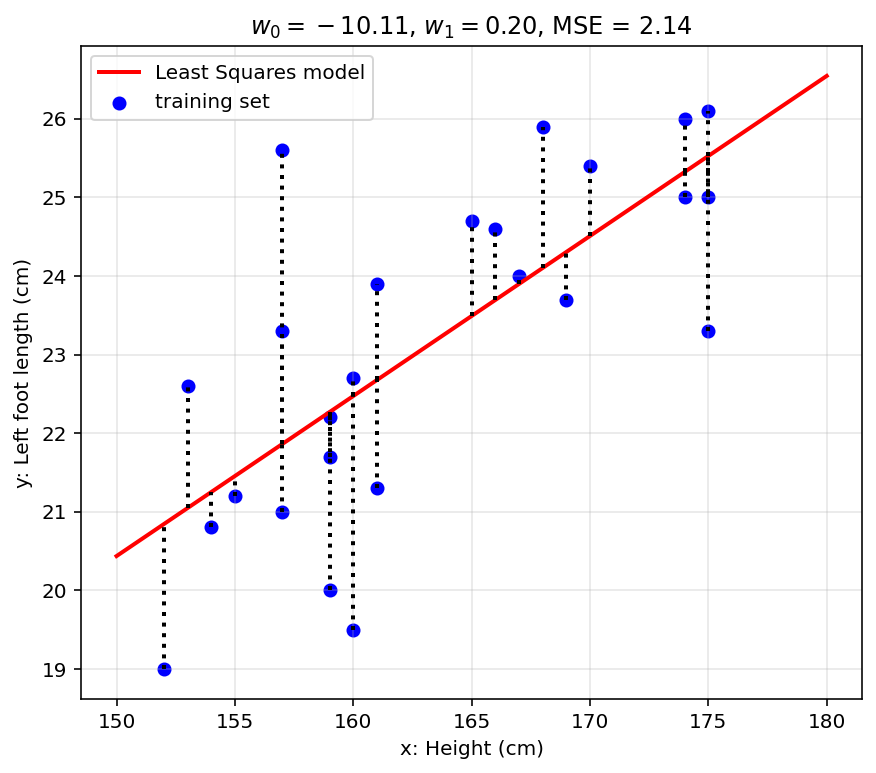

In [14]:
plt.figure(figsize=(7,6))

#plot training data
plt.scatter(x_train, y_train, marker='o', color='blue', label='training set')

# retrieve w0 and w1 from the solution of the optimization
w_0 = w[0]
w_1 = w[1]

# predictions for the training data
s_ = w_0 + x_train * w_1

# MSE of the training data
mse = np.mean((s_ - y_train)**2)

# to plot the line
xg = np.linspace(150,180,10)
yg = w_0 + xg * w_1
plt.plot(xg,yg,linewidth=2,label='Least Squares model', color='red')
plt.xlabel('x: Height (cm)')
plt.ylabel('y: Left foot length (cm)')
plt.title('$w_0 = {0:.2f}$, $w_1 = {1:.2f}$, MSE = {2:.2f}'.format(w_0, w_1, mse))
plt.grid(alpha=0.3)

for jj, xt in enumerate(x_train):
    if s_[jj] > y_train[jj]:
        y1 = y_train[jj]
        y2 = s_[jj]
    else:
        y2 = y_train[jj]
        y1 = s_[jj]
    plt.plot([xt,xt],[y1,y2], linestyle=':', linewidth=2, color='black')
_=plt.legend()

plt.savefig('height_foot_2.png')

### And make inference with test data

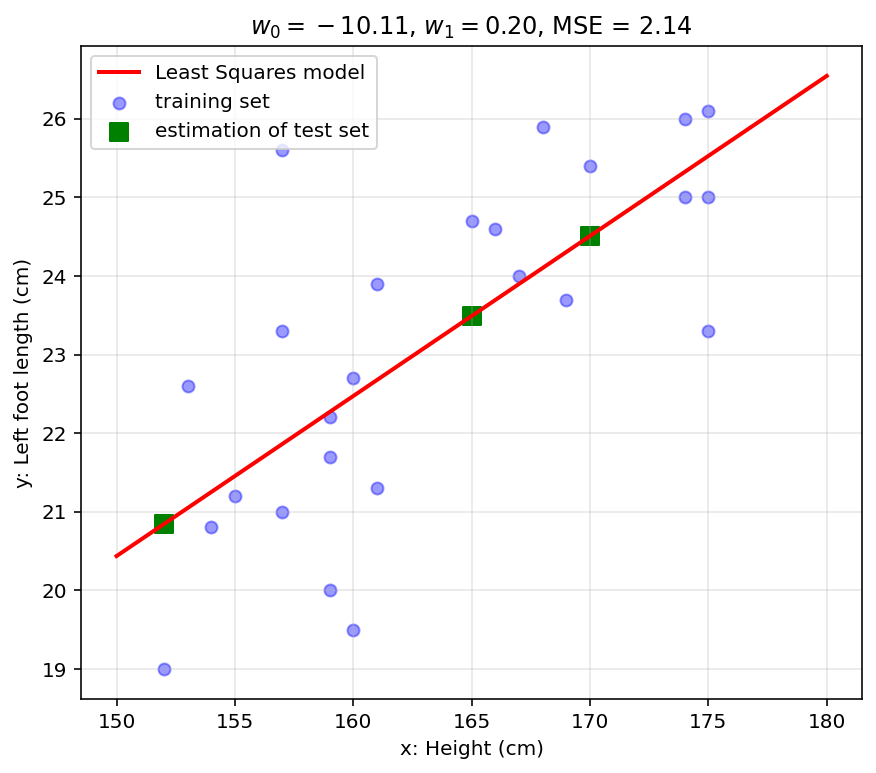

In [15]:
plt.figure(figsize=(7,6))

# plot training data
plt.scatter(x_train, y_train, marker='o', color='blue', label='training set',alpha=0.4)

# plot line
xg = np.linspace(150,180,10)
yg = w_0 + xg * w_1
plt.plot(xg,yg,linewidth=2,label='Least Squares model', color='red')
plt.xlabel('x: Height (cm)')
plt.ylabel('y: Left foot length (cm)')
plt.title('$w_0 = {0:.2f}$, $w_1 = {1:.2f}$, MSE = {2:.2f}'.format(w_0, w_1, mse))
plt.grid(alpha=0.3)

# make predictions for test data
s_test = x_test * w_1 + w_0

# plot predictions for test data
plt.scatter(x_test, s_test, marker='s', s=80, color='green',label='estimation of test set')
_=plt.legend()

## Multivariate problems

So far we have solved the case in which the inputs are scalars, $x\in \mathbb R$. But most of the times your inputs will have more than one feature, $\mathbf x \in \mathbb R^d$.

The strategy to solve the multivariate linear regression problem is pretty straightforward. Consider a data matrix $X$ where every row is an observation

$$
X = \left[ \begin{array}{c} \mathbf x_1^\top \\ \mathbf x_2^\top \\ \vdots \\ \mathbf x_N^\top \end{array} \right]_{N\times d}
$$

The model will be
$$
y \approx f(\mathbf x) = \mathbf x^\top \mathbf w + w_0 = \left [\begin{array}{cc} \mathbf x^\top & 1 \end{array}\right ]\left [\begin{array}{c} \mathbf w \\ w_0 \end{array}\right ]
$$

The pseudoinverse solution can be applied using directly $X_e$, a matrix formed by stacking $X$ with a column of $n$ ones.

$$
\mathbf w = (X_e^\top X_e)^{-1} X_e^\top \mathbf y
$$


Notice $\mathbf w$ has $d +1$ elements, one per each dimension of $\mathbf x$ plus the bias term $w_0$.

# Semilinear Regression

## One dimensional case

Sometimes a linear model is not enough to capture the relationship between inputs and targets, and one needs to be able to add non-linearities in the model design. 

For example, consider that the super-toy problem is defined with these three samples

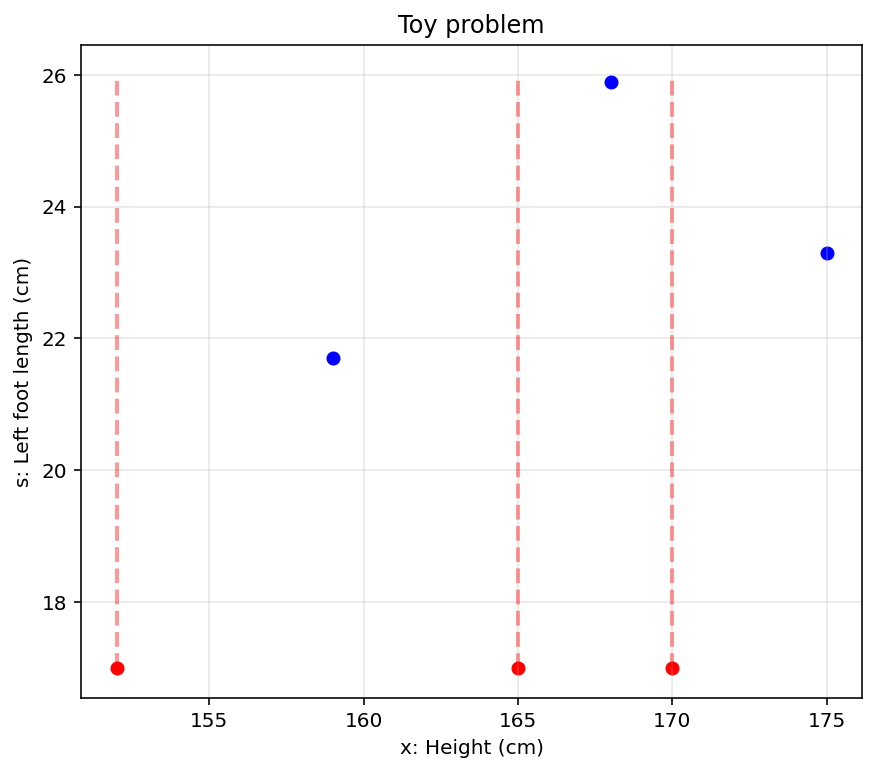

In [16]:
x_toy_q = x_train[[12,16,21]]
y_toy_q = y_train[[12,16,21]]

ff,aa = plt.subplots(1,1,figsize=(7,6))
aa.scatter(x_toy_q, y_toy_q, marker='o', color='blue', label='training set')
aa.set_xlabel('x: Height (cm)')
aa.set_ylabel('s: Left foot length (cm)')
aa.set_title('Toy problem')
aa.grid(alpha=0.3)
aa.scatter(x_test, 17*np.ones(3), marker='o', color='red', label='test observations')
for ii, xt in enumerate(x_test): 
    aa.plot([xt,xt],[17,26], linestyle='--', linewidth=2, color='red', alpha=0.4)

In this case perhaps a linear solution is not the first thing that you would think of. 



Solution: w_0 = 4.04, w_1 = 0.12


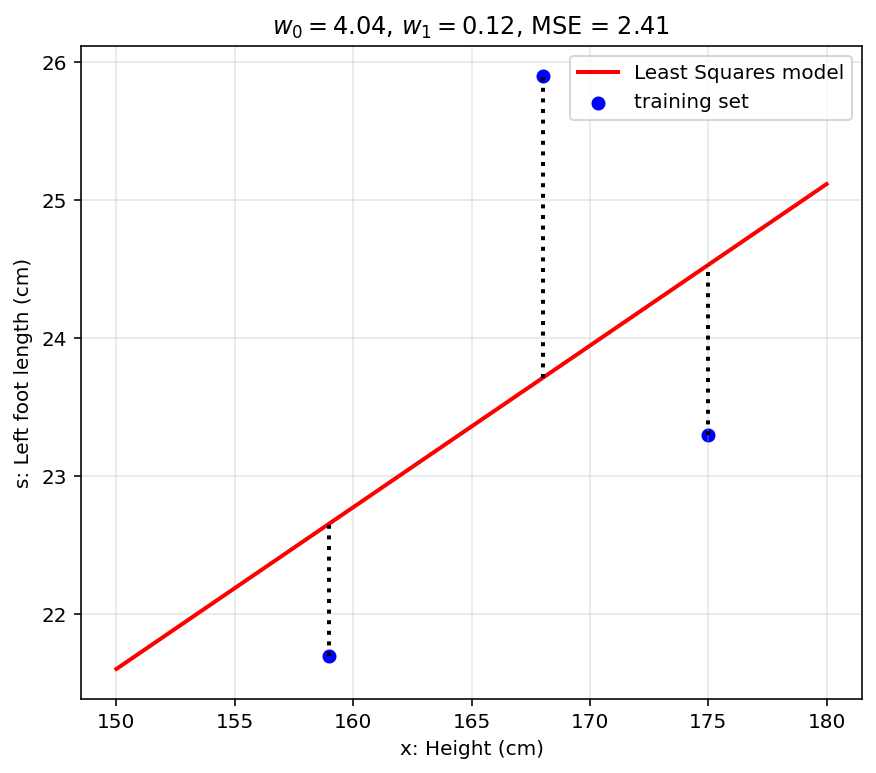

In [17]:

# add column with ones for the bias term
Xe = np.vstack((np.ones(len(x_toy_q)), x_toy_q)).T

# find out linear regression model through pseudoinverse
w = np.linalg.inv(Xe.T.dot(Xe)).dot(Xe.T).dot(y_toy_q)

print('Solution: w_0 = {0:.2f}, w_1 = {1:.2f}'.format(w[0], w[1]))

# plot
plt.figure(figsize=(7,6))

# plot training data
plt.scatter(x_toy_q, y_toy_q, marker='o', color='blue', label='training set')

# retrieve model parameters
w_0 = w[0]
w_1 = w[1]

# compute prediction for the training data
s_toy = w_0 + x_toy_q * w_1

# compute MSE in the training data
mse = np.mean((s_toy - y_toy_q)**2)

# to plot the line
xg = np.linspace(150,180,10)
yg = w_0 + xg * w_1
plt.plot(xg,yg,linewidth=2,label='Least Squares model', color='red')
plt.xlabel('x: Height (cm)')
plt.ylabel('s: Left foot length (cm)')
plt.title('$w_0 = {0:.2f}$, $w_1 = {1:.2f}$, MSE = {2:.2f}'.format(w_0, w_1, mse))
plt.grid(alpha=0.3)

# to plot the error in each individual training observation

for jj, xt in enumerate(x_toy_q):
    if s_toy[jj] > y_toy_q[jj]:
        y1 = y_toy_q[jj]
        y2 = s_toy[jj]
    else:
        y2 = y_toy_q[jj]
        y1 = s_toy[jj]
    plt.plot([xt,xt],[y1,y2], linestyle=':', linewidth=2, color='black')
_=plt.legend()

Perhaps you are more prone to **believe** the mapping used by the data generator is a quadratic function
$$
f(x) = w_0 + w_1 x + w_2 x^2
$$

Therefore now you need to learn values for three constants $w_0$, $w_1$ and $w_2$


## Extend the linear model to a quadratic one

### Add a column with the square of $x$

$$
w_0 + w_1x + w_2x^2 = \left[ \begin{array}{ccc}1 & x & x^2 \end{array} \right]\left[ \begin{array}{c}w_0 \\ w_1 \\ w_2 \end{array} \right]
$$

The output to all the training observations can be represented in matrix form as as

$$
\left[ \begin{array}{ccc}1 & x^{(1)} & (x^{(1)})^2\\ 1 & x^{(2)} & (x^{(2)})^2 \\ 1 & x^{(3)} &  (x^{(3)})^2\end{array} \right]\left[ \begin{array}{c}w_0 \\ w_1 \\w_2 \end{array} \right] = \left[  \begin{array}{c}w_0 + w_1 x^{(1)} + w_2(x^{(1)})^2 \\ w_0 + w_1 x^{(2)} + w_2(x^{(2)})^2 \\w_0 + w_1 x^{(3)} + w_2(x^{(3)})^2 \end{array} \right] 
$$


**Change the notation of the inputs from $x^{(i)}$ to $x_i$**

So the approximation error can be written in vector form as

$$
 \left[  \begin{array}{c}y_1 - w_0 - w_1 x_1 - w_2x_1^2\\y_2 -  w_0 - w_1 x_2 - w_2x_2^2 \\y_3 - w_0 - w_1 x_3 - w_2x_3^2 \end{array} \right]  = \left[ \begin{array}{c}y_1 \\ y_2 \\ y_3 \end{array} \right] - \left[ \begin{array}{ccc}1 & x_1 & x_1^2 \\ 1 & x_2 & x_2^2 \\ 1 & x_3 & x_3^2 \end{array} \right]\left[ \begin{array}{c}w_0 \\ w_1 \\w_2 \end{array} \right] = \mathbf y - X\mathbf w
$$

And the sum of squares of the approximation errors can be calculated as
$$
 \left( \mathbf y - X\mathbf w\right)^\top \left( \mathbf y - X\mathbf w\right)
$$

Therefore the optimization problem can be casted into matrix form as

$$
\min_{\mathbf w} \left( \mathbf y - X\mathbf w\right)^\top \left( \mathbf y - X\mathbf w\right)
$$

And the Pseudo inverse is still a valid solution for this problem


Solution: w_0 = -1451.70, w_1 = 17.60, w_2 = -0.05


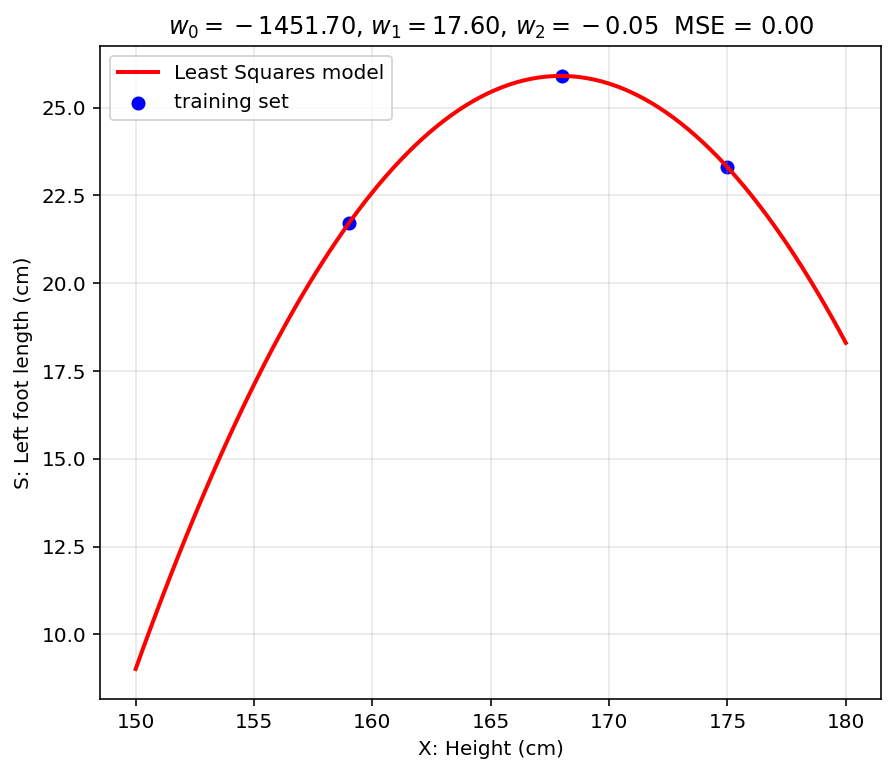

In [18]:
# prepare training matrix with 3 columns: ones, x, x**2
Xe = np.vstack((np.ones(len(x_toy_q)), x_toy_q, x_toy_q**2)).T

# Pseudoinverse to obtain model w0, w1 and w2
w = np.linalg.inv(Xe.T.dot(Xe)).dot(Xe.T).dot(y_toy_q)
print('Solution: w_0 = {0:.2f}, w_1 = {1:.2f}, w_2 = {2:.2f}'.format(w[0], w[1], w[2]))

# plot
plt.figure(figsize=(7,6))

# plot training data
plt.scatter(x_toy_q, y_toy_q, marker='o', color='blue', label='training set')

# apply model to training data to obtain predictions for training data
w_0 = w[0]
w_1 = w[1]
w_2 = w[2]
s_toy = w_0 + x_toy_q * w_1 + x_toy_q**2 * w_2

# compute MSE to the training data
mse = np.mean((s_toy - y_toy_q)**2)

# plot
xg = np.linspace(150,180,100)
yg = w_0 + xg * w_1 + xg**2 * w_2
plt.plot(xg,yg,linewidth=2,label='Least Squares model', color='red')
plt.xlabel('X: Height (cm)')
plt.ylabel('S: Left foot length (cm)')
plt.title('$w_0 = {0:.2f}$, $w_1 = {1:.2f}$, $w_2 = {2:.2f}$  MSE = {3:.2f}'.format(w_0, w_1, w_2, mse))
plt.grid(alpha=0.3)

for jj, xt in enumerate(x_toy_q):
    if s_toy[jj] > y_toy_q[jj]:
        y1 = y_toy_q[jj]
        y2 = s_toy[jj]
    else:
        y2 = y_toy_q[jj]
        y1 = s_toy[jj]
    plt.plot([xt,xt],[y1,y2], linestyle=':', linewidth=2, color='black')
_=plt.legend()

### Estimation errors
| Observed input ($x$)     |Observed output ($y$)| Estimation ($\hat s$) | Estimation Error $(s-\hat s)$ | Square Error ($(s-\hat s)^2$) | 
| :---        |    :----:   | :----:| :----:   | :----:   | 
    |  168     | 25.9 | 25.9 | 0|0 |
    |175 | 23.3 | 23.3 | 0| 0 |
    | 158 |21.7 | 21.7 | 0| 0 |
    
Wow, it seems we've found the perfect model!!

### Now use the whole training dataset to build the model

Solution: w_0 = -127.92, w_1 = 1.64 ,w_2 = -0.00


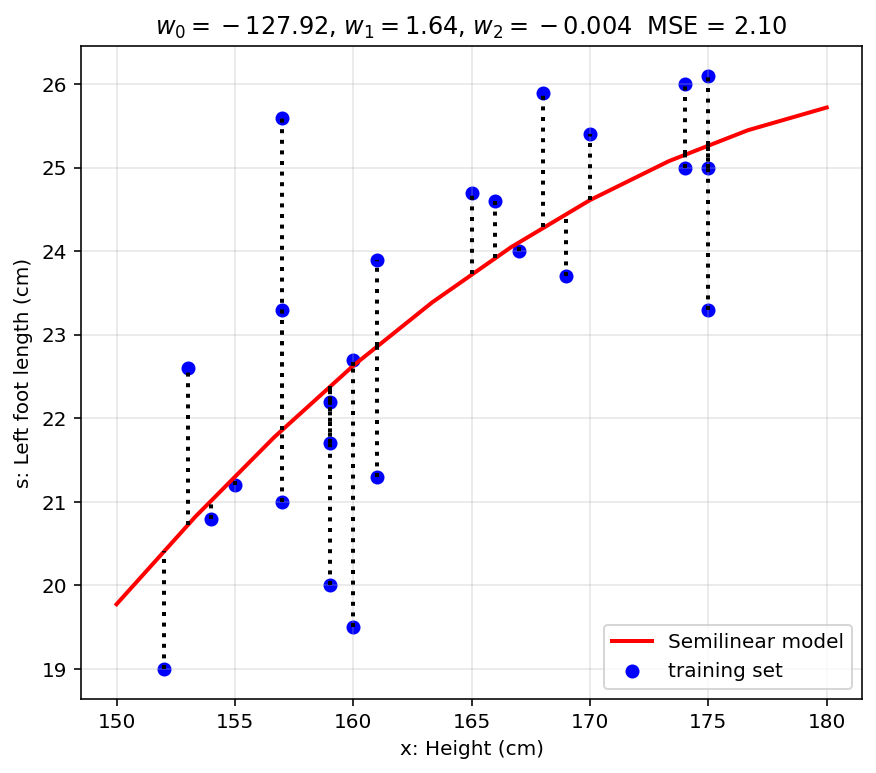

In [19]:
# prepare training matrix with 3 columns: ones, x, x**2
Xe = np.vstack((np.ones(len(x_train)), x_train, x_train**2)).T
w = np.linalg.inv(Xe.T.dot(Xe)).dot(Xe.T).dot(y_train)
print('Solution: w_0 = {0:.2f}, w_1 = {1:.2f} ,w_2 = {2:.2f}'.format(w[0], w[1], w[2]))
plt.figure(figsize=(7,6))
plt.scatter(x_train, y_train, marker='o', color='blue', label='training set')
w_0 = w[0]
w_1 = w[1]
w_2 = w[2]
s_ = Xe.dot(w)
mse = np.mean((s_ - y_train)**2)
xg = np.linspace(150,180,10)
yg = w_0 + xg * w_1 + xg**2 * w_2
plt.plot(xg,yg,linewidth=2,label='Semilinear model', color='red')
plt.xlabel('x: Height (cm)')
plt.ylabel('s: Left foot length (cm)')
plt.title('$w_0 = {0:.2f}$, $w_1 = {1:.2f}$, $w_2 = {2:.3f}$  MSE = {3:.2f}'.format(w_0, w_1, w_2, mse))
plt.grid(alpha=0.3)

for jj, xt in enumerate(x_train):
    if s_[jj] > y_train[jj]:
        y1 = y_train[jj]
        y2 = s_[jj]
    else:
        y2 = y_train[jj]
        y1 = s_[jj]
    plt.plot([xt,xt],[y1,y2], linestyle=':', linewidth=2, color='black')
_=plt.legend()

plt.savefig('height_foot_3.png')

## Other non-linearities

$$
\begin{array}{lcl}
f_1(x) &=& w_0+w_1x\\   
f_2(x) &=& w_0+w_1x+w_2 x^2\\
f_3(x) &=& w_0+w_1x+w_2 x^2+w_3 x^3 \\
f_4(x) &=& w_0+w_1x+w_2x^2+w_3 \cos(x)\\ 
\end{array}
$$

### $f_3(x) = w_0+w_1x+w_2 x^2+w_3 x^3 $

Solution: w_0 = 3468.14, w_1 = -64.39 ,w_2 = 0.40, w_3 = -0.001


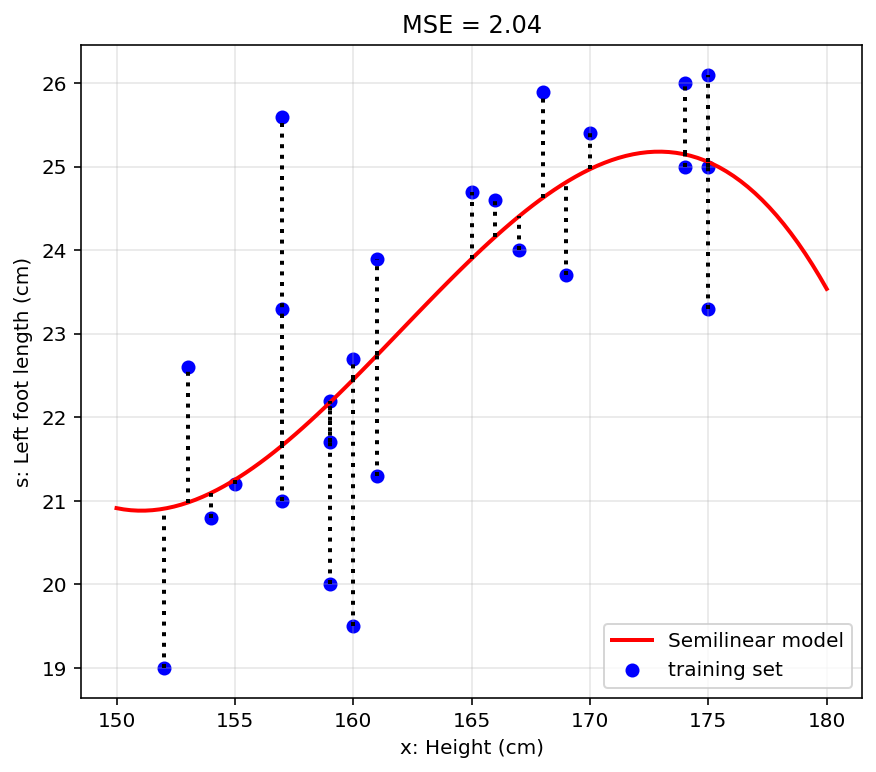

In [20]:
# prepare training matrix with 4 columns: ones, x, x**2, x**3
Xe = np.vstack((np.ones(len(x_train)), x_train, x_train**2, x_train**3)).T

# pseudoinverse
w = np.linalg.inv(Xe.T.dot(Xe)).dot(Xe.T).dot(y_train)
print('Solution: w_0 = {0:.2f}, w_1 = {1:.2f} ,w_2 = {2:.2f}, w_3 = {3:.3f}'.format(w[0], w[1], w[2], w[3]))
plt.figure(figsize=(7,6))
plt.scatter(x_train, y_train, marker='o', color='blue', label='training set')
w_0 = w[0]
w_1 = w[1]
w_2 = w[2]
w_3 = w[3]
s_ = Xe.dot(w)
error = np.mean((s_ - y_train)**2)
xg = np.linspace(150,180,100)
yg = w_0 + xg * w_1 + xg**2 * w_2 + xg**3 * w_3
plt.plot(xg,yg,linewidth=2,label='Semilinear model', color='red')
plt.xlabel('x: Height (cm)')
plt.ylabel('s: Left foot length (cm)')
plt.title('MSE = {0:.2f}'.format(error))
plt.grid(alpha=0.3)

for jj, xt in enumerate(x_train):
    if s_[jj] > y_train[jj]:
        y1 = y_train[jj]
        y2 = s_[jj]
    else:
        y2 = y_train[jj]
        y1 = s_[jj]
    plt.plot([xt,xt],[y1,y2], linestyle=':', linewidth=2, color='black')
_=plt.legend()
plt.savefig('height_foot_4.png')

### $f_4(x) = w_0+w_1x+w_2x^2+w_3 \cos(x)$

Solution: w_0 = -183.33, w_1 = 2.33 ,w_2 = -0.01, w_3 = 0.539


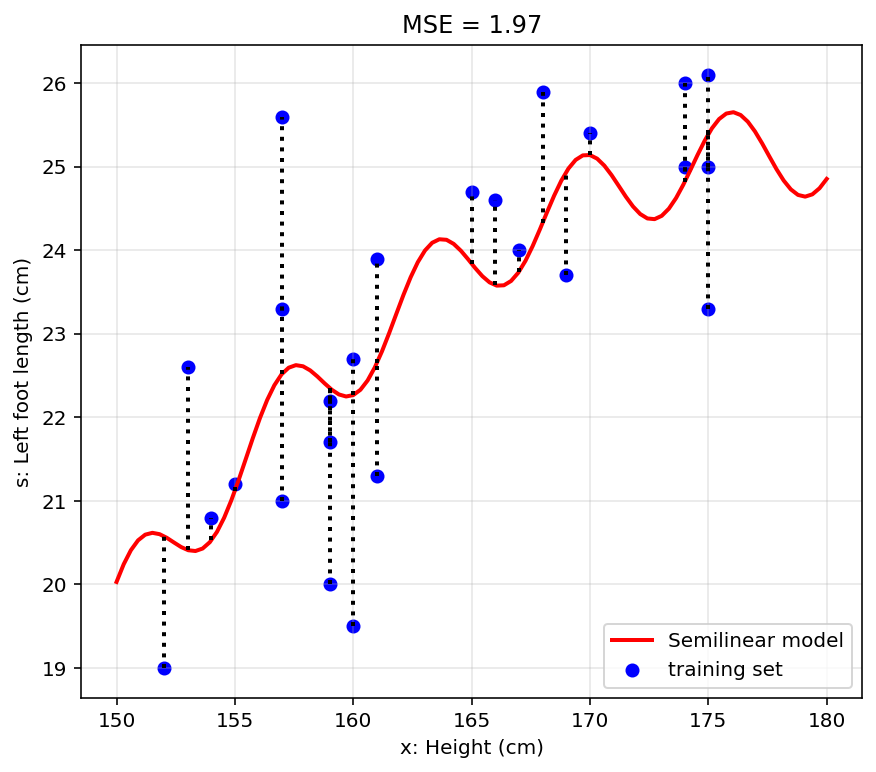

In [21]:

# prepare training matrix with 4 columns: ones, x, x**2, cos(x)
Xe = np.vstack((np.ones(len(x_train)), x_train, x_train**2, np.cos(x_train))).T

w = np.linalg.inv(Xe.T.dot(Xe)).dot(Xe.T).dot(y_train)
print('Solution: w_0 = {0:.2f}, w_1 = {1:.2f} ,w_2 = {2:.2f}, w_3 = {3:.3f}'.format(w[0], w[1], w[2], w[3]))
plt.figure(figsize=(7,6))
plt.scatter(x_train, y_train, marker='o', color='blue', label='training set')
w_0 = w[0]
w_1 = w[1]
w_2 = w[2]
w_3 = w[3]
s_ = Xe.dot(w)
error = np.mean((s_ - y_train)**2)
xg = np.linspace(150,180,100)
yg = w_0 + xg * w_1 + xg**2 * w_2 + np.cos(xg) * w_3
plt.plot(xg,yg,linewidth=2,label='Semilinear model', color='red')
plt.xlabel('x: Height (cm)')
plt.ylabel('s: Left foot length (cm)')
plt.title('MSE = {0:.2f}'.format(error))
plt.grid(alpha=0.3)

for jj, xt in enumerate(x_train):
    if s_[jj] > y_train[jj]:
        y1 = y_train[jj]
        y2 = s_[jj]
    else:
        y2 = y_train[jj]
        y1 = s_[jj]
    plt.plot([xt,xt],[y1,y2], linestyle=':', linewidth=2, color='black')
_=plt.legend()
plt.savefig('height_foot_5.png')

# Generalization

- So far we have evaluated how well does our model **fit the training data**
- This is useful to explain how this data was generated but...
- What about the performance in new data?
- **Generalization capability**: We expect the model to perform in new data as well as in the training data

## Revisit the Toy-er problem with the linear and the quadratic solutions

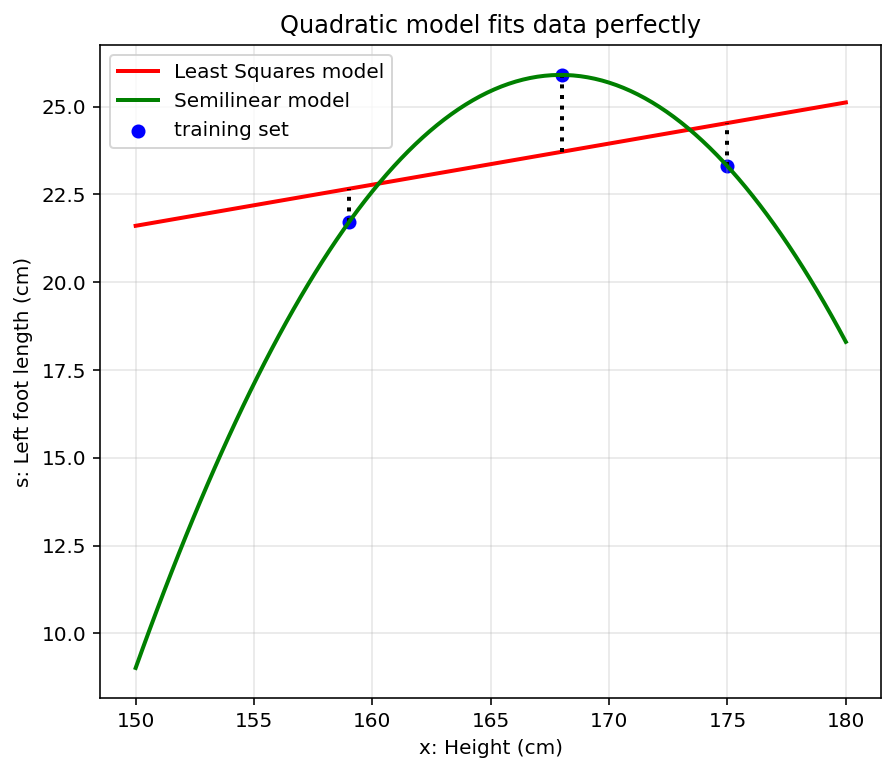

In [22]:
Xe = np.vstack((np.ones(len(x_toy_q)), x_toy_q)).T
w = np.linalg.inv(Xe.T.dot(Xe)).dot(Xe.T).dot(y_toy_q)
xtt = 179
stt_l = w[0] + xtt*w[1]
plt.figure(figsize=(7,6))
plt.title('Quadratic model fits data perfectly')
plt.scatter(x_toy_q, y_toy_q, marker='o', color='blue', label='training set')
w_0 = w[0]
w_1 = w[1]
s_toy = w_0 + x_toy_q * w_1
error = np.mean((s_toy - y_toy_q)**2)
xg = np.linspace(150,180,100)
yg = w_0 + xg * w_1
plt.plot(xg,yg,linewidth=2,label='Least Squares model', color='red')
plt.xlabel('x: Height (cm)')
plt.ylabel('s: Left foot length (cm)')

plt.grid(alpha=0.3)

for jj, xt in enumerate(x_toy_q):
    if s_toy[jj] > y_toy_q[jj]:
        y1 = y_toy_q[jj]
        y2 = s_toy[jj]
    else:
        y2 = y_toy_q[jj]
        y1 = s_toy[jj]
    plt.plot([xt,xt],[y1,y2], linestyle=':', linewidth=2, color='black')
plt.legend()

Xe = np.vstack((np.ones(len(x_toy_q)), x_toy_q, x_toy_q**2)).T
w = np.linalg.inv(Xe.T.dot(Xe)).dot(Xe.T).dot(y_toy_q)
xtt = 179
stt_q = w[0] + xtt*w[1] + xtt**2 * w[2]
w_0 = w[0]
w_1 = w[1]
w_2 = w[2]
s_toy = w_0 + x_toy_q * w_1 + x_toy_q**2 * w_2
error = np.mean((s_toy - y_toy_q)**2)

yg = w_0 + xg * w_1 + xg**2 * w_2
plt.plot(xg,yg,linewidth=2,label='Semilinear model', color='green')

plt.grid(alpha=0.3)

for jj, xt in enumerate(x_toy_q):
    if s_toy[jj] > y_toy_q[jj]:
        y1 = y_toy_q[jj]
        y2 = s_toy[jj]
    else:
        y2 = y_toy_q[jj]
        y1 = s_toy[jj]
    plt.plot([xt,xt],[y1,y2], linestyle=':', linewidth=2, color='violet')
_=plt.legend()

### Now observe a test input

- Test sample: $x_t = 179$cm
- Prediction with the linear model: $\hat s_l = 24.9$ cm in the left foot
- Prediction with the quadratic model: $\hat s_q = 19.5$ cm in the left foot

- **The quadratic model overfits**

- **The linear model generalizes better**

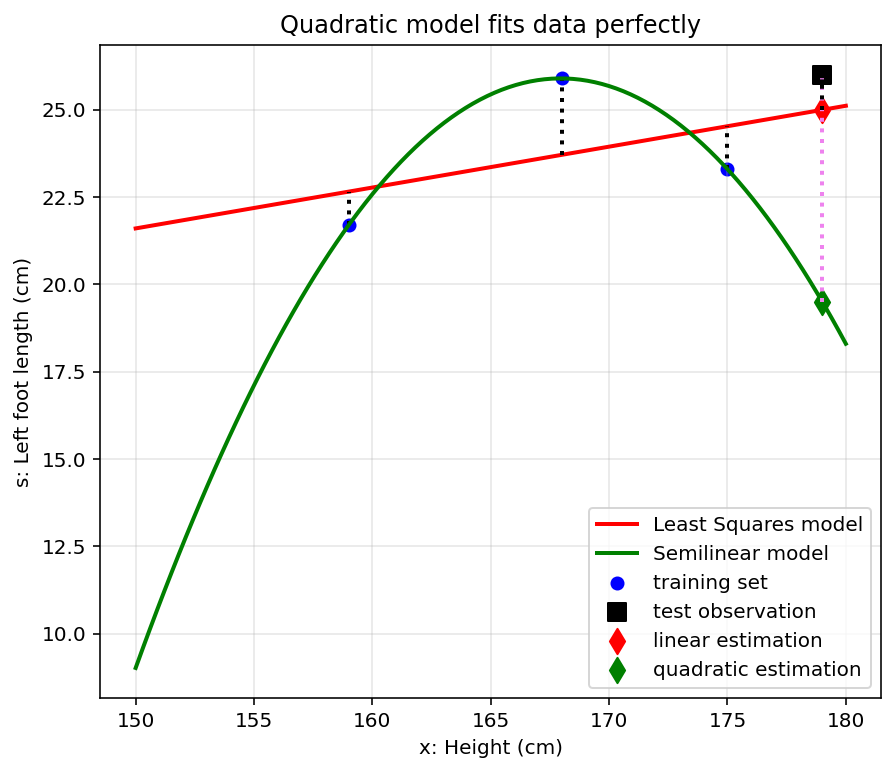

In [23]:
Xe = np.vstack((np.ones(len(x_toy_q)), x_toy_q)).T
w = np.linalg.inv(Xe.T.dot(Xe)).dot(Xe.T).dot(y_toy_q)
xtt = 179
ytt = 26
stt_l = w[0] + xtt*w[1]
plt.figure(figsize=(7,6))
plt.title('Quadratic model fits data perfectly')
plt.scatter(x_toy_q, y_toy_q, marker='o', color='blue', label='training set')
w_0 = w[0]
w_1 = w[1]
s_toy = w_0 + x_toy_q * w_1
error = np.mean((s_toy - y_toy_q)**2)
xg = np.linspace(150,180,100)
yg = w_0 + xg * w_1
plt.plot(xg,yg,linewidth=2,label='Least Squares model', color='red')
plt.xlabel('x: Height (cm)')
plt.ylabel('s: Left foot length (cm)')

plt.grid(alpha=0.3)

for jj, xt in enumerate(x_toy_q):
    if s_toy[jj] > y_toy_q[jj]:
        y1 = y_toy_q[jj]
        y2 = s_toy[jj]
    else:
        y2 = y_toy_q[jj]
        y1 = s_toy[jj]
    plt.plot([xt,xt],[y1,y2], linestyle=':', linewidth=2, color='black')
plt.legend()

Xe = np.vstack((np.ones(len(x_toy_q)), x_toy_q, x_toy_q**2)).T
w = np.linalg.inv(Xe.T.dot(Xe)).dot(Xe.T).dot(y_toy_q)
xtt = 179
stt_q = w[0] + xtt*w[1] + xtt**2 * w[2]
w_0 = w[0]
w_1 = w[1]
w_2 = w[2]
s_toy = w_0 + x_toy_q * w_1 + x_toy_q**2 * w_2
error = np.mean((s_toy - y_toy_q)**2)

yg = w_0 + xg * w_1 + xg**2 * w_2
plt.plot(xg,yg,linewidth=2,label='Semilinear model', color='green')

plt.grid(alpha=0.3)

for jj, xt in enumerate(x_toy_q):
    if s_toy[jj] > y_toy_q[jj]:
        y1 = y_toy_q[jj]
        y2 = s_toy[jj]
    else:
        y2 = y_toy_q[jj]
        y1 = s_toy[jj]
    plt.plot([xt,xt],[y1,y2], linestyle=':', linewidth=2, color='violet')

plt.scatter(xtt,ytt,marker='s', s=80, color='black',label='test observation')
plt.scatter(xtt,stt_l,marker='d', s=80, color='red',label='linear estimation')
plt.scatter(xtt,stt_q,marker='d', s=80, color='green',label='quadratic estimation')
plt.plot([xtt,xtt],[stt_q,ytt], linestyle=':', linewidth=2, color='violet')
plt.plot([xtt,xtt],[stt_l,ytt], linestyle=':', linewidth=2, color='black')

_=plt.legend()

Yes, the quadratic model overfits...

### but did anyone in the room expected that an increase in height would mean a decrease in the length of the left foot?

## Prior domain knowledge!

The length of the left foot in general increases with the height of the owner of the foot. We don't know how is this increase, if it is linear or not, but it is clear that the mapping can't decrease with height!

## Split data into training and validation

In those cases in which we do not have enough prior knowledge to decide which model complexity is the one we need, a common strategy is to split the available data into two subsets: the **training set** and the **validation set**. 

The training set is used to **fit** the model parameters, and the validation set is used to **evaluate** the performance of those parameters with **unseen data**. Remember we are ultimately interested in accurate estimations for unseen data.

There is a easy way to carry out this splitting in scikit learn, the function [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

Applied to our case

Solution: w_0 = -6.13, w_1 = 0.18
Solution: w_0 = 157.02, w_1 = -1.80 ,w_2 = 0.01


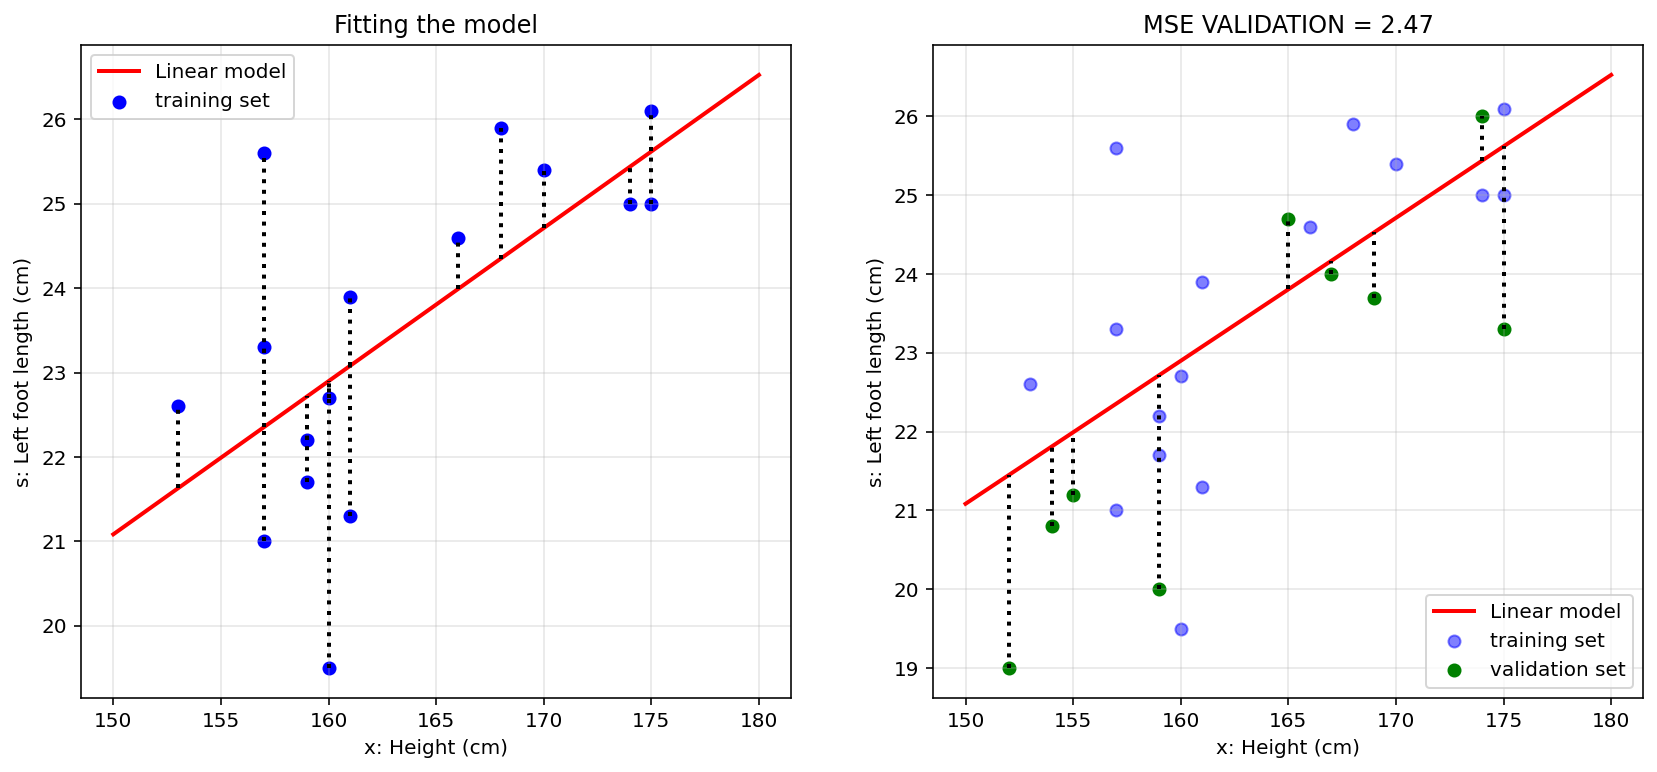

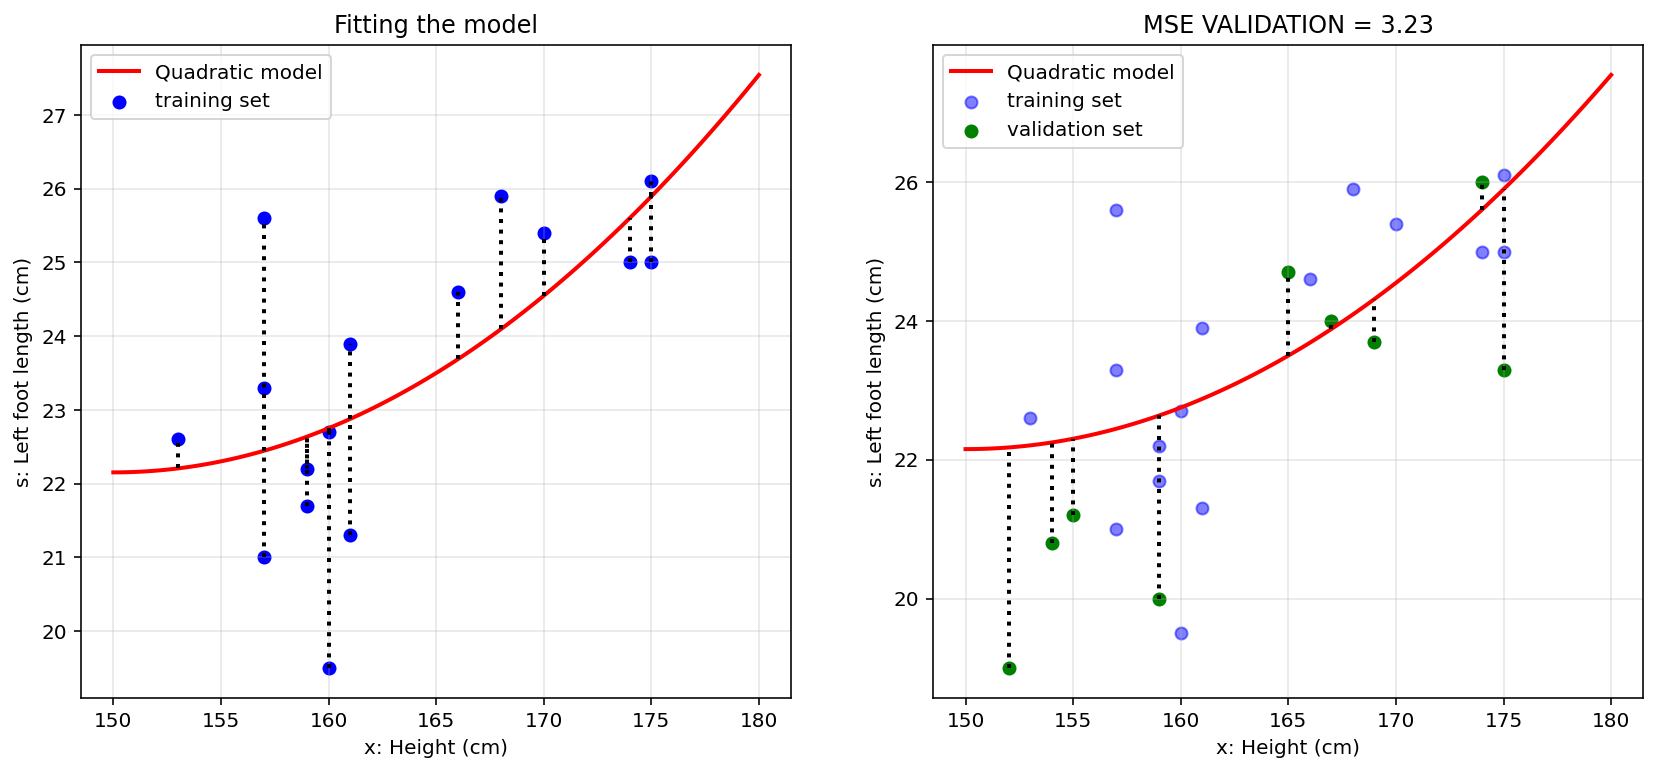

In [24]:
from sklearn.model_selection import train_test_split

XTRAIN, XVALIDATION, YTRAIN, YVALIDATION = train_test_split(x_train, 
                                                y_train, 
                                                test_size=0.33, 
                                                random_state=42)

Xe = np.vstack((np.ones(len(XTRAIN)), XTRAIN)).T
w = np.linalg.inv(Xe.T.dot(Xe)).dot(Xe.T).dot(YTRAIN)
print('Solution: w_0 = {0:.2f}, w_1 = {1:.2f}'.format(w[0], w[1]))
ff,aa = plt.subplots(1,2,figsize=(14,6))

aa[0].scatter(XTRAIN, YTRAIN, marker='o', color='blue', label='training set')
aa[1].scatter(XTRAIN, YTRAIN, marker='o', color='blue', label='training set', alpha=0.5)

aa[0].set_title('Fitting the model')
aa[1].scatter(XVALIDATION, YVALIDATION, marker='o', color='green', label='validation set')
w_0 = w[0]
w_1 = w[1]

Xv = np.vstack((np.ones(len(XVALIDATION)), XVALIDATION)).T
s_ = Xv.dot(w)
s_train = Xe.dot(w)
error = np.mean((s_ - YVALIDATION)**2)
xg = np.linspace(150,180,100)
yg = w_0 + xg * w_1  
aa[0].plot(xg,yg,linewidth=2,label='Linear model', color='red')
aa[0].set_xlabel('x: Height (cm)')
aa[0].set_ylabel('s: Left foot length (cm)')
aa[1].plot(xg,yg,linewidth=2,label='Linear model', color='red')
aa[1].set_xlabel('x: Height (cm)')
aa[1].set_ylabel('s: Left foot length (cm)')
aa[1].set_title('MSE VALIDATION = {0:.2f}'.format(error))
aa[0].grid(alpha=0.3)
aa[1].grid(alpha=0.3)

for jj, xt in enumerate(XTRAIN):
    if s_train[jj] > YTRAIN[jj]:
        y1 = YTRAIN[jj]
        y2 = s_train[jj]
    else:
        y2 = YTRAIN[jj]
        y1 = s_train[jj]
    aa[0].plot([xt,xt],[y1,y2], linestyle=':', linewidth=2, color='black')

for jj, xt in enumerate(XVALIDATION):
    if s_[jj] > YVALIDATION[jj]:
        y1 = YVALIDATION[jj]
        y2 = s_[jj]
    else:
        y2 = YVALIDATION[jj]
        y1 = s_[jj]
    aa[1].plot([xt,xt],[y1,y2], linestyle=':', linewidth=2, color='black')
_=aa[1].legend()
_=aa[0].legend()


Xe = np.vstack((np.ones(len(XTRAIN)), XTRAIN, XTRAIN**2)).T
w = np.linalg.inv(Xe.T.dot(Xe)).dot(Xe.T).dot(YTRAIN)
print('Solution: w_0 = {0:.2f}, w_1 = {1:.2f} ,w_2 = {2:.2f}'.format(w[0], w[1], w[2]))
ff,aa = plt.subplots(1,2,figsize=(14,6))

aa[0].scatter(XTRAIN, YTRAIN, marker='o', color='blue', label='training set')
aa[1].scatter(XTRAIN, YTRAIN, marker='o', color='blue', label='training set', alpha=0.5)

aa[0].set_title('Fitting the model')
aa[1].scatter(XVALIDATION, YVALIDATION, marker='o', color='green', label='validation set')
w_0 = w[0]
w_1 = w[1]
w_2 = w[2]

Xv = np.vstack((np.ones(len(XVALIDATION)), XVALIDATION, XVALIDATION**2)).T
s_ = Xv.dot(w)
s_train = Xe.dot(w)
error = np.mean((s_ - YVALIDATION)**2)
xg = np.linspace(150,180,100)
yg = w_0 + xg * w_1 + xg**2 * w_2 
aa[0].plot(xg,yg,linewidth=2,label='Quadratic model', color='red')
aa[0].set_xlabel('x: Height (cm)')
aa[0].set_ylabel('s: Left foot length (cm)')
aa[1].plot(xg,yg,linewidth=2,label='Quadratic model', color='red')
aa[1].set_xlabel('x: Height (cm)')
aa[1].set_ylabel('s: Left foot length (cm)')
aa[1].set_title('MSE VALIDATION = {0:.2f}'.format(error))
aa[0].grid(alpha=0.3)
aa[1].grid(alpha=0.3)

for jj, xt in enumerate(XTRAIN):
    if s_train[jj] > YTRAIN[jj]:
        y1 = YTRAIN[jj]
        y2 = s_train[jj]
    else:
        y2 = YTRAIN[jj]
        y1 = s_train[jj]
    aa[0].plot([xt,xt],[y1,y2], linestyle=':', linewidth=2, color='black')

for jj, xt in enumerate(XVALIDATION):
    if s_[jj] > YVALIDATION[jj]:
        y1 = YVALIDATION[jj]
        y2 = s_[jj]
    else:
        y2 = YVALIDATION[jj]
        y1 = s_[jj]
    aa[1].plot([xt,xt],[y1,y2], linestyle=':', linewidth=2, color='black')
_=aa[1].legend()
_=aa[0].legend()

We would stick to the Linear Model as it yields the lowest MSE in the validation set.

## Semilinear regression as a multivariate problem

Adding columns to $X$ is in fact converting the one dimensional problem in a multivariate one, where each added column is a new component in the observation. The extended observation now lives in a **higher dimension** space. In fact, the procedure of adding columns can be regarded as **mapping the input data into a new space with a higher dimensionality**. This space in machine learning is usually called **Feature Space**, as it is the space defined by the **features** that form the data.

### Example: solve the height-foot length problem with a nonlinear mapping point of view

1. First we **select the nonlinear mapping**. In order to be able to plot it, we choose a mapping onto two dimensions

$$\mathbf h(): x \longrightarrow \mathbf h(x) = \left[ \begin{array}{c} h_1(x) \\ h_2(x) \end{array} \right ] = \left[ \begin{array}{c} cos(x) \\ \sin(x) \end{array} \right ] \in \mathbb R^2$$

2. Construct data matrix in Feature Space $H$

$$H= \left[ \begin{array}{c} \mathbf h(x_1)^\top \\ \mathbf h(x_2)^\top\\ \vdots \\ \mathbf h(x_N)^\top\end{array} \right]_{N\times 2} = \left[ \begin{array}{cc} h_1(x_1) & h_2(x_1) \\ h_1(x_2) & h_2(x_2) \\ \vdots & \vdots \\ h_1(x_N) & h_2(x_N)\end{array} \right]_{N\times 2} =
\left[ \begin{array}{cc} \cos(x_1) & \sin(x_1) \\ \cos(x_2) & \sin(x_2) \\ \vdots & \vdots \\ \cos(x_N) & \sin(x_N)\end{array} \right]_{N\times 2}$$

3. Solve a linear regression with $H$
    
  - Extend $H$ with a column of ones 
$$H_e = \left[ \begin{array}{ccc} 1 & h_{1,1} & h_{1,2} \\ 1 & h_{2,1} & h_{2,2} \\ \vdots & \vdots \\ 1 & h_{N,1} & h_{N,2}\end{array} \right]_{N\times 2}$$
    
  - Compute the pseudoinverse
$$
    \mathbf v = \left[ \begin{array}{c} v_0 \\ v_1 \\ v_2\end{array} \right] = (H^\top H)^{-1}H^\top \mathbf s
$$
    
The **linear model in feature space** is in fact a **nonlinear model in input space**.

$$
y = \mathbf v^\top \mathbf h = v_0 + v_1 h_1 + v_2 h_2 = v_0 + v_1 \cos(x) + v_2 \sin(x) 
$$

In [25]:
from mpl_toolkits.mplot3d import Axes3D 
def draw_linear_map_3d(ax, linear_map, xmin=-1, xmax=1, ymin=-1, ymax=1):
  npoints=100
  Xg = np.linspace(xmin-.05*np.absolute(xmin),
                   xmax + .05*np.absolute(xmax),
                   npoints) # or whatever values for x
    
  Yg = np.linspace(ymin-.05*np.absolute(ymin),
                   ymax + .05*np.absolute(ymax),
                   npoints)   # or whatever values for y
  X, Y = np.meshgrid(Xg, Yg)
  Xshape = X.shape
    
  x_test = np.hstack((X.reshape(-1,1), Y.reshape(-1,1)))
  zz = linear_map(x_test)
  zz = zz.reshape(Xshape)
  return ax.plot_surface(X, Y, zz, cmap='PuOr',
                       linewidth=0, antialiased=False)

In [26]:
# Build non-linear mapping
h1 = np.cos(x_train) #x_train has the height of the subjects
h2 = np.sin(x_train)


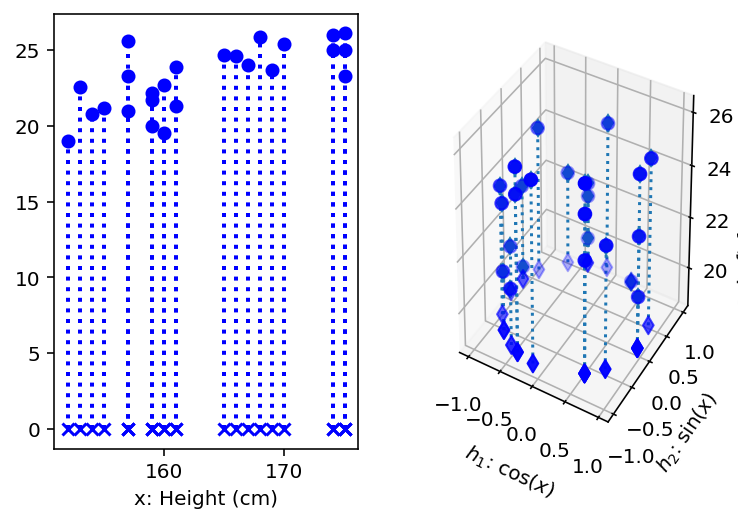

In [27]:
%matplotlib inline
import mpl_toolkits.mplot3d.art3d as art3d
ff = plt.figure()

aa = ff.add_subplot(1, 2, 1)

aa.scatter(x_train, y_train, marker='o', color='blue', label='training set')
aa.scatter(x_train, np.zeros(len(y_train)), marker='x', color='blue', label='training set')
for jj, xt in enumerate(x_train):
    y1 = 0
    y2 = y_train[jj]
    aa.plot([xt,xt],[y1,y2], linestyle=':', linewidth=2, color='blue')
aa.set_xlabel('x: Height (cm)')
aa.set_ylabel('')

bb = ff.add_subplot(1, 2, 2, projection='3d')
bb.scatter(h1, h2, y_train, marker='o', s=40, color='blue', label='mapped training set')
bb.scatter(h1, h2, np.ones(len(y_train))*19, marker='d', s=40, color='blue', label='mapped training set')

for xi, yi, zi in zip(h1, h2, y_train):        
    line=art3d.Line3D(*zip((xi, yi, 19), (xi, yi, zi)), marker='d', markevery=(1, 1), linestyle=':')
    bb.add_line(line)
bb.set_xlabel('$h_1$: cos($x$)')
bb.set_ylabel('$h_2$: sin($x$)')
bb.set_zlabel('s: Left foot length (cm)')
plt.show()

In [28]:
# extend H
He = np.vstack((np.ones(len(h1)), h1, h2)).T
# pseudoinverse
v = np.linalg.inv(He.T.dot(He)).dot(He.T).dot(y_train)

In [29]:
def vh(h):
    he = np.hstack((np.ones(len(h)).reshape(-1,1), h))
    return he.dot(v)

Text(0.5, 0.92, '$\\hat y(h_1,h_2)$')

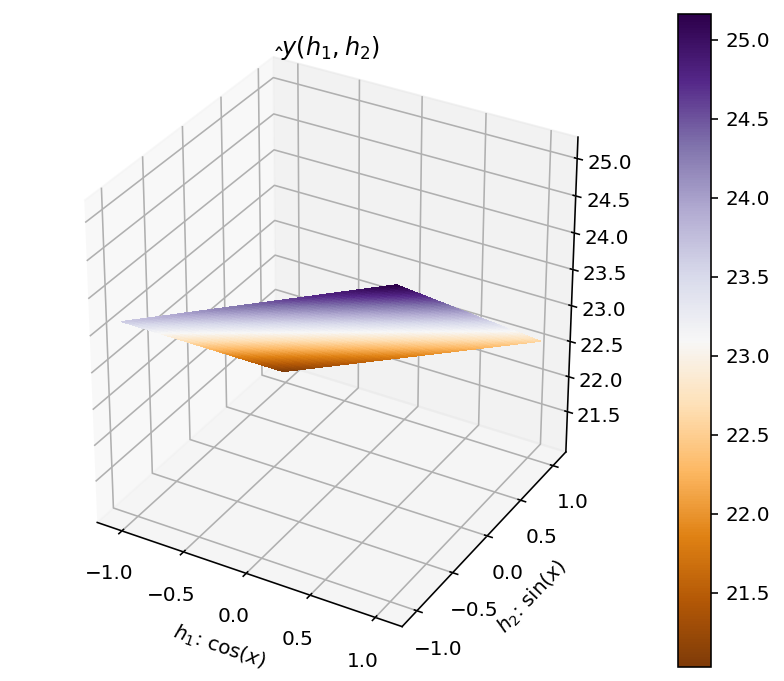

In [30]:
fig = plt.figure(figsize=(7,6))
aa = fig.add_subplot(111, projection='3d')

xmin=-1, 
xmax=1, 
ymin=-1, 
ymax=1
npoints=100
Xg = np.linspace(xmin-.05*np.absolute(xmin),
                   xmax + .05*np.absolute(xmax),
                   npoints) # or whatever values for x
    
Yg = np.linspace(ymin-.05*np.absolute(ymin),
                   ymax + .05*np.absolute(ymax),
                   npoints)   # or whatever values for y
X, Y = np.meshgrid(Xg, Yg)
Xshape = X.shape
    
x_test = np.hstack((X.reshape(-1,1), Y.reshape(-1,1)))
zz = vh(x_test)
zz = zz.reshape(Xshape)
hh=aa.plot_surface(X, Y, zz, cmap='PuOr',
                       linewidth=0, antialiased=False)
fig.colorbar(hh,ax=aa)
aa.set_xlabel('$h_1$: cos($x$)')
aa.set_ylabel('$h_2$: sin($x$)')
aa.set_title('$\\hat y(h_1,h_2)$')

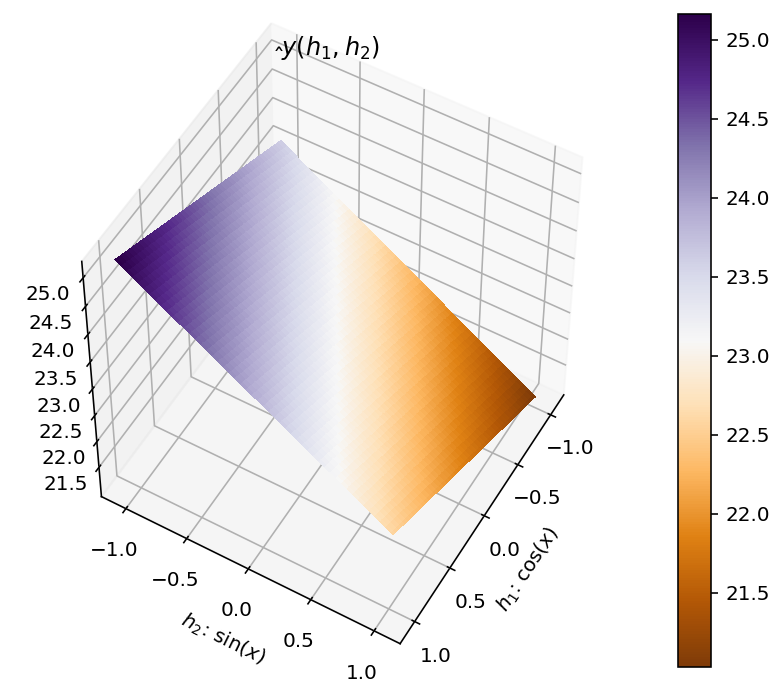

In [31]:
aa.view_init(50, 30)
fig

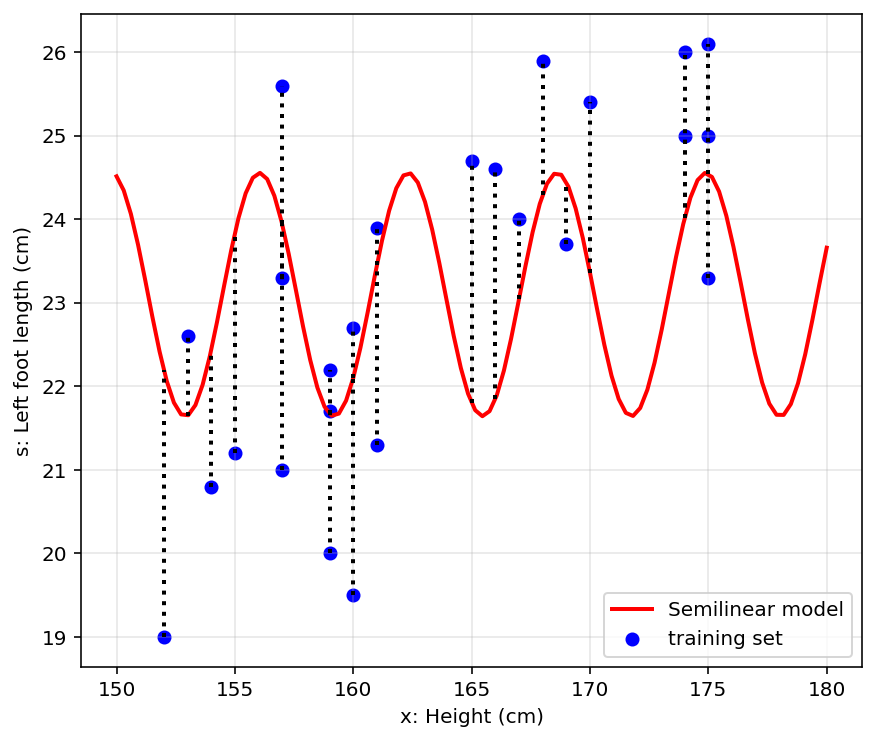

In [32]:
%matplotlib inline
plt.figure(figsize=(7,6))
plt.scatter(x_train, y_train, marker='o', color='blue', label='training set')
xg = np.linspace(150,180,100)
Hg = np.vstack((np.ones(len(xg)), np.cos(xg), np.sin(xg))).T
yg = Hg.dot(v)
plt.plot(xg,yg,linewidth=2,label='Semilinear model', color='red')
plt.xlabel('x: Height (cm)')
plt.ylabel('s: Left foot length (cm)')
plt.grid(alpha=0.3)
s_ = He.dot(v)
for jj, xt in enumerate(x_train):
    if s_[jj] > y_train[jj]:
        y1 = y_train[jj]
        y2 = s_[jj]
    else:
        y2 = y_train[jj]
        y1 = s_[jj]
    plt.plot([xt,xt],[y1,y2], linestyle=':', linewidth=2, color='black')
_=plt.legend()

### Example: solve the height-foot length problem with a nonlinear mapping point of view of the semilinear quadratic solution


In [33]:
# Build non-linear mapping
h1 = x_train
h2 = x_train ** 2


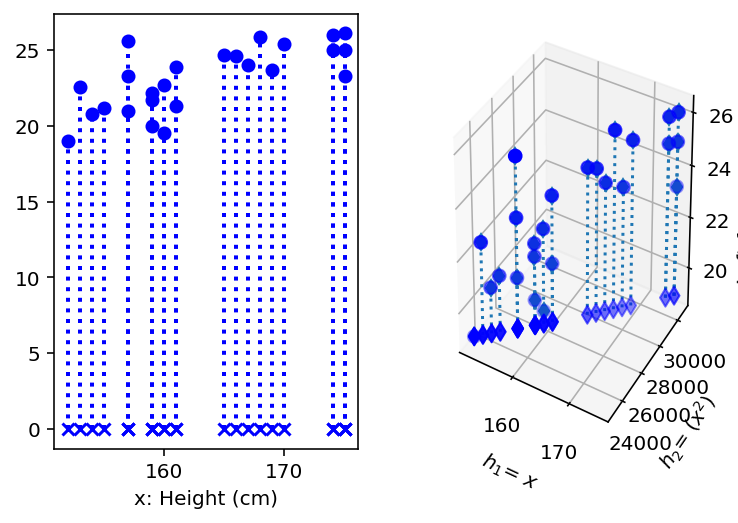

In [34]:

ff = plt.figure()

aa = ff.add_subplot(1, 2, 1)

aa.scatter(x_train, y_train, marker='o', color='blue', label='training set')
aa.scatter(x_train, np.zeros(len(y_train)), marker='x', color='blue', label='training set')
for jj, xt in enumerate(x_train):
    y1 = 0
    y2 = y_train[jj]
    aa.plot([xt,xt],[y1,y2], linestyle=':', linewidth=2, color='blue')
aa.set_xlabel('x: Height (cm)')
aa.set_ylabel('')

bb = ff.add_subplot(1, 2, 2, projection='3d')
bb.scatter(h1, h2, y_train, marker='o', s=40, color='blue', label='mapped training set')
bb.scatter(h1, h2, np.ones(len(y_train))*19, marker='d', s=40, color='blue', label='mapped training set')

for xi, yi, zi in zip(h1, h2, y_train):        
    line=art3d.Line3D(*zip((xi, yi, 19), (xi, yi, zi)), marker='d', markevery=(1, 1), linestyle=':')
    bb.add_line(line)
bb.set_xlabel('$h_1$= $x$')
bb.set_ylabel('$h_2$= ($x^2$)')
bb.set_zlabel('s: Left foot length (cm)')
plt.show()

In [35]:
# extend H
He = np.vstack((np.ones(len(h1)), h1, h2)).T
# pseudoinverse
v = np.linalg.inv(He.T.dot(He)).dot(He.T).dot(y_train)


In [36]:
def vh(h):
    he = np.hstack((np.ones(len(h)).reshape(-1,1), h))
    return he.dot(v)

Text(0.5, 0.92, '$\\hat s(h_1,h_2)$')

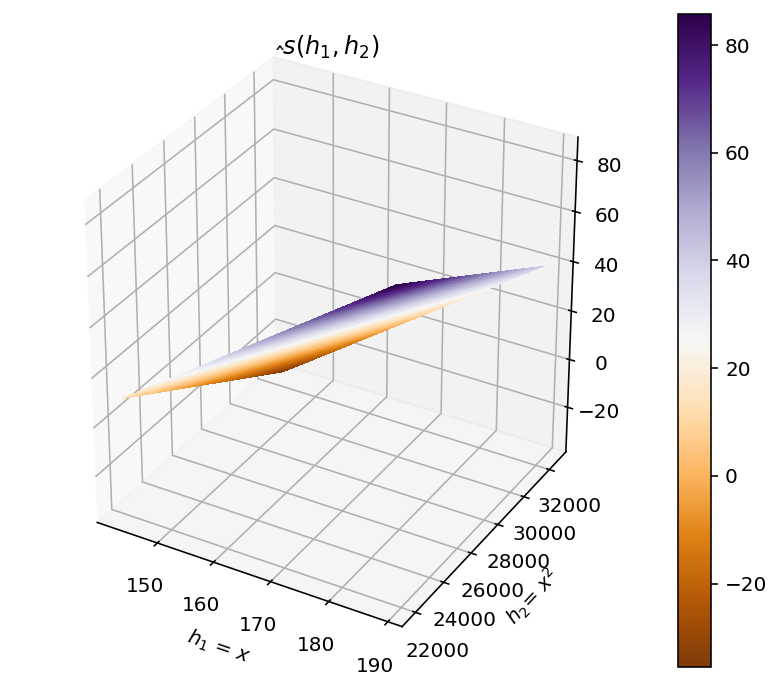

In [37]:
#%matplotlib notebook
fig = plt.figure(figsize=(7,6))
aa = fig.add_subplot(111, projection='3d')

xmin=150, 
xmax=180, 
ymin=23000, 
ymax=31000
npoints=100
Xg = np.linspace(xmin-.05*np.absolute(xmin),
                   xmax + .05*np.absolute(xmax),
                   npoints) # or whatever values for x
    
Yg = np.linspace(ymin-.05*np.absolute(ymin),
                   ymax + .05*np.absolute(ymax),
                   npoints)   # or whatever values for y
X, Y = np.meshgrid(Xg, Yg)
Xshape = X.shape
    
x_test = np.hstack((X.reshape(-1,1), Y.reshape(-1,1)))
zz = vh(x_test)
zz = zz.reshape(Xshape)
hh=aa.plot_surface(X, Y, zz, cmap='PuOr',
                       linewidth=0, antialiased=False)
fig.colorbar(hh,ax=aa)
aa.set_xlabel('$h_1$ = $x$')
aa.set_ylabel('$h_2$= $x^2$')
aa.set_title('$\\hat s(h_1,h_2)$')

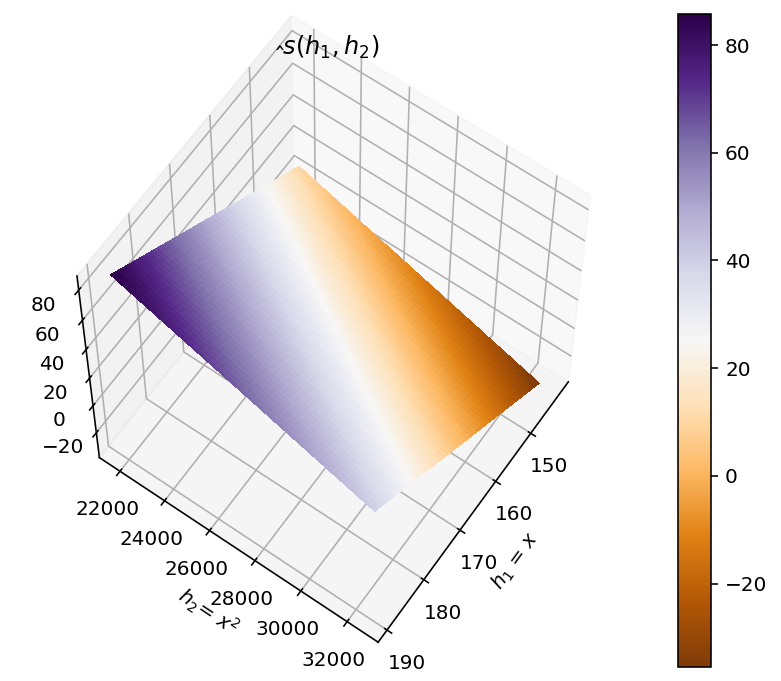

In [38]:
aa.view_init(60, 35)
fig

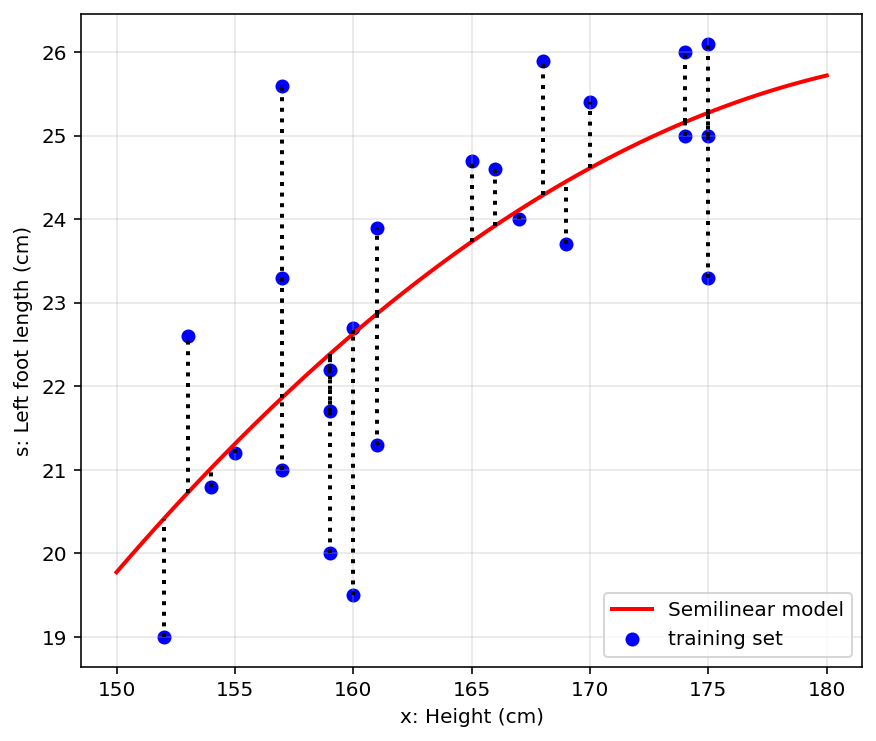

In [39]:
%matplotlib inline
plt.figure(figsize=(7,6))
plt.scatter(x_train, y_train, marker='o', color='blue', label='training set')
xg = np.linspace(150,180,100)
Hg = np.vstack((np.ones(len(xg)), xg, xg**2)).T
yg = Hg.dot(v)
plt.plot(xg,yg,linewidth=2,label='Semilinear model', color='red')
plt.xlabel('x: Height (cm)')
plt.ylabel('s: Left foot length (cm)')
plt.grid(alpha=0.3)
s_ = He.dot(v)
for jj, xt in enumerate(x_train):
    if s_[jj] > y_train[jj]:
        y1 = y_train[jj]
        y2 = s_[jj]
    else:
        y2 = y_train[jj]
        y1 = s_[jj]
    plt.plot([xt,xt],[y1,y2], linestyle=':', linewidth=2, color='black')
_=plt.legend()

# Regression with Scikit Learn

The linear regression that we have introduced is already implemented in [scikit learn](https://scikit-learn.org/stable/index.html), the poweful machine learning toolbox for python that we will be using in the machine learning part of the course.

Examine the model documentation of the class [`LinearRegression()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)


The scikit learn machine learning implementations have three main methods to deploy the models:
- `fit`: to learn the free parameters of the model, like the weights in the linear regression case
- `predict`: to do inference with a test set
- `score`: to evaluate the performance of the model in a test set with available true targets

Generate data

In [40]:
def ff(x, a=1.2, b=3):
  return np.exp(-a*x)*np.cos(b*np.pi*x)

In [41]:
a = 1.2
n=20
x = np.linspace(-2,2,n)
xg = np.linspace(-2,2,2000)
y = ff(x)
yg = ff(xg)
sigma_n = 1
y += np.array([random.gauss(mu=0, sigma=sigma_n) for ii in range(n)])
my = np.mean(y)

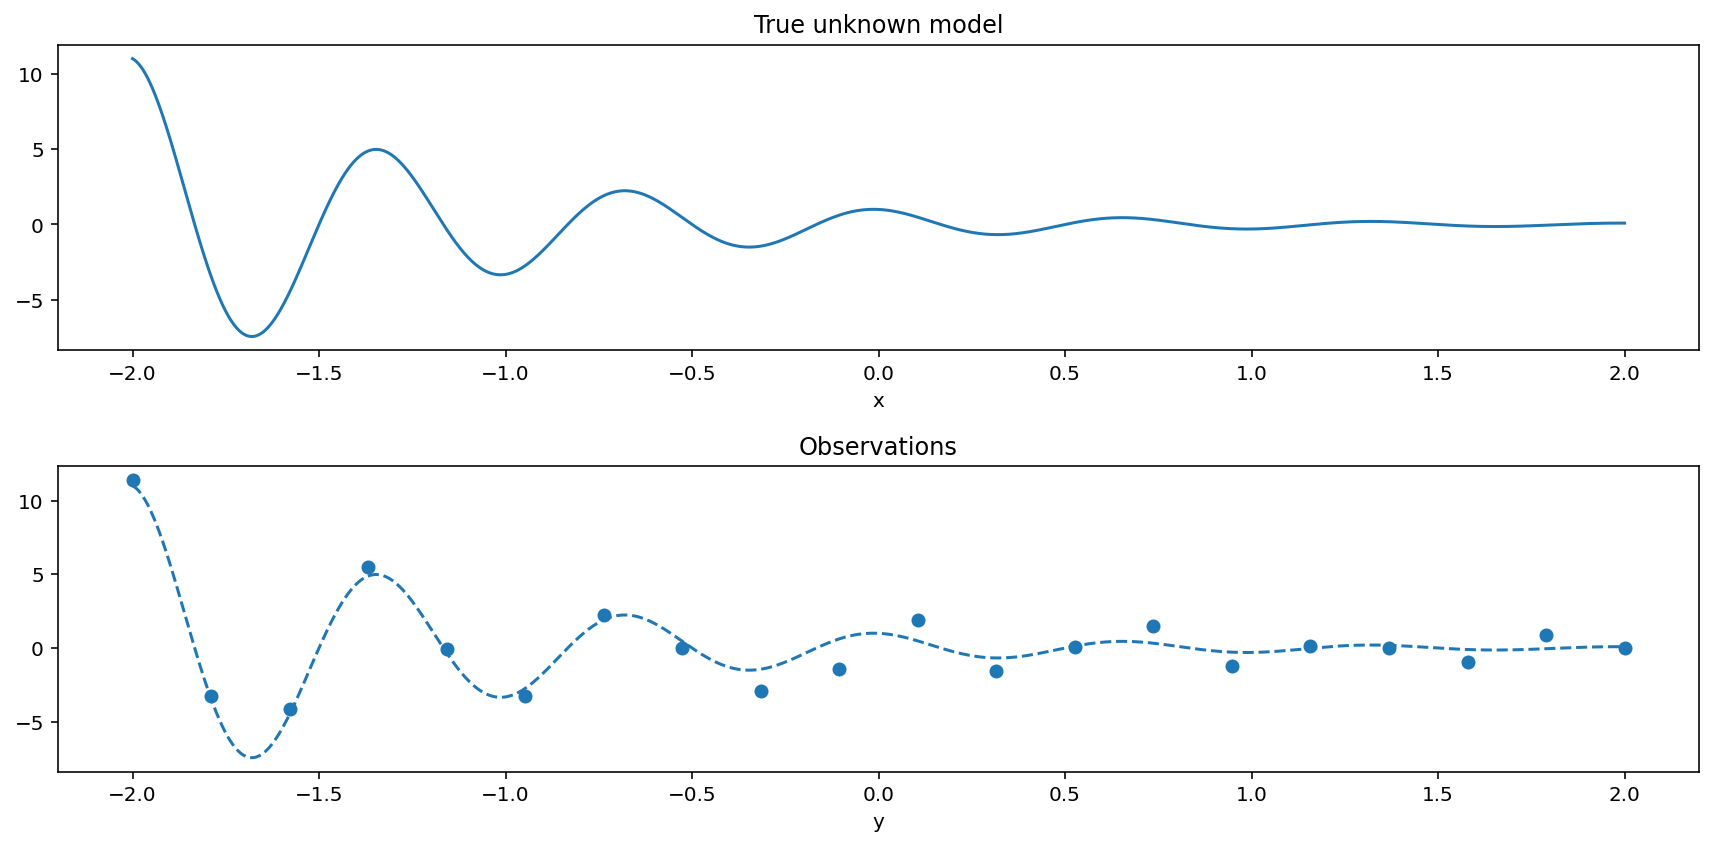

In [42]:
fa, aa = plt.subplots(2,1,figsize=(12,6))
aa[0].plot(xg,yg,label='ff(x)')
aa[0].set_xlabel('x')
aa[0].set_title('True unknown model')
aa[1].scatter(x,y)
aa[1].plot(xg,yg,linestyle='--',label='underlying ff(x)')
aa[1].set_xlabel('x')
aa[1].set_xlabel('y')
aa[1].set_title('Observations')

fa.tight_layout()



1. Instantiate the model

In [43]:
from sklearn.linear_model import LinearRegression

In [44]:
LR = LinearRegression()

2. Call fit with the training data

In [45]:
LR.fit(x.reshape(-1,1),y)

LinearRegression()

When the model is fit, we can inspect the values of the parameters

In [46]:
print('weight w1: ')
print(LR.coef_)
print('bias term w0: {0:.3f}'.format(LR.intercept_))

weight w1: 
[-0.52239625]
bias term w0: 0.239


3. Do inference with test data

In [47]:
y_pred = LR.predict(x.reshape(-1,1))
yg_pred = LR.predict(xg.reshape(-1,1))
#y_alt = xg * LR.coef_ + LR.intercept_
#print(y_pred-y_alt)

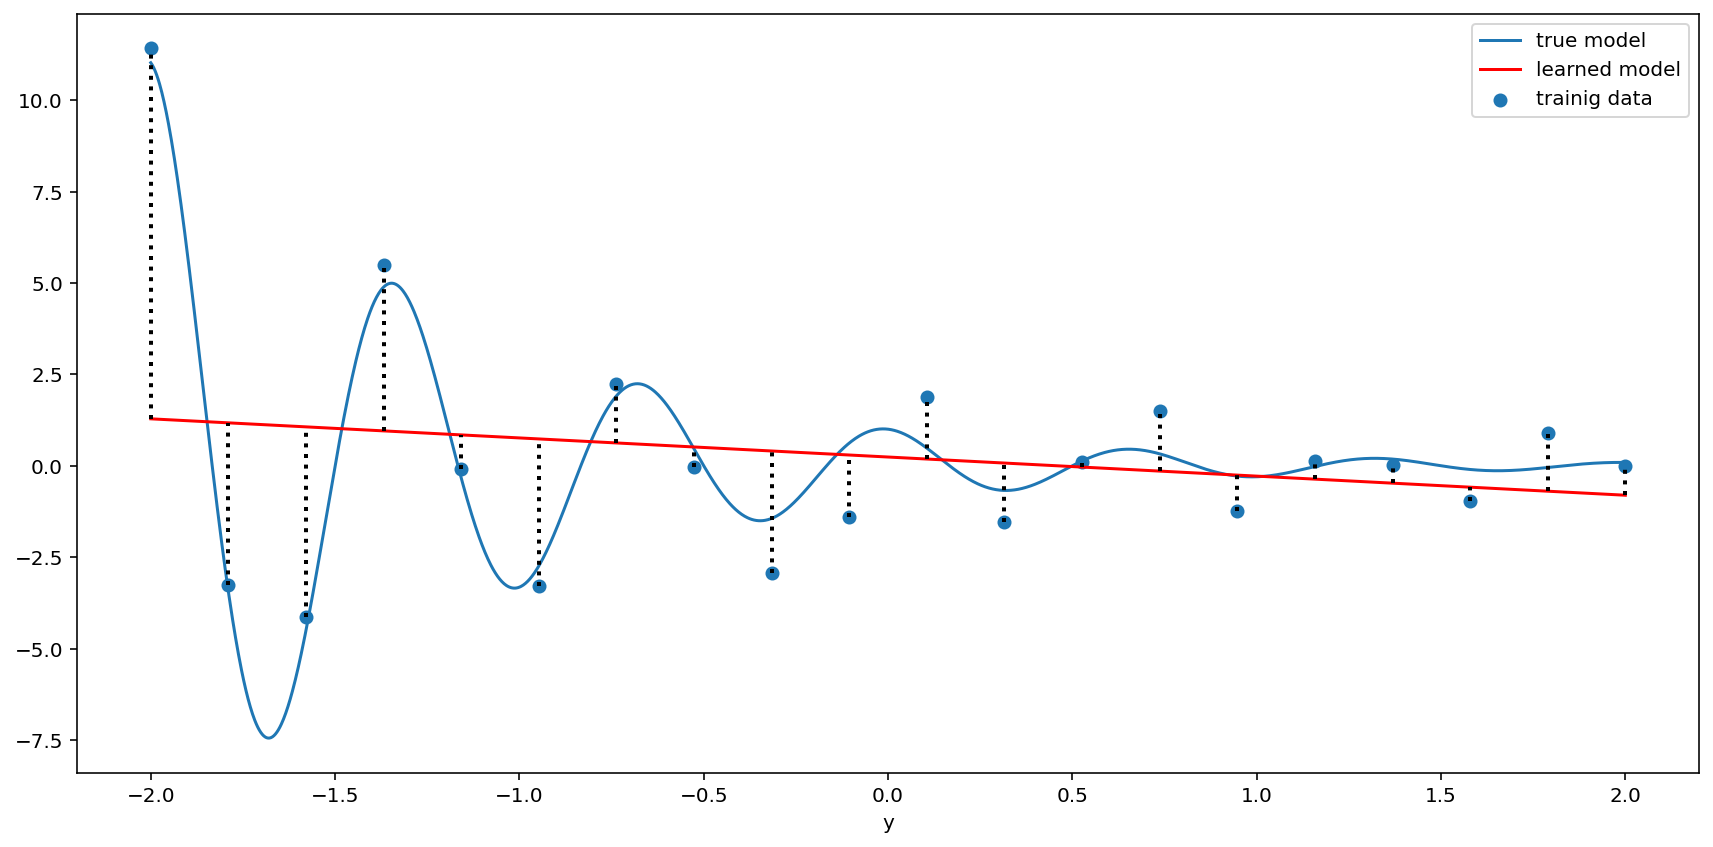

In [48]:
fa, aa = plt.subplots(1,1,figsize=(12,6))
aa.plot(xg,yg,label='true model')
aa.set_xlabel('x')
aa.scatter(x,y, label='trainig data')
aa.set_xlabel('y')
aa.plot(xg,yg_pred,color='red',label='learned model')
aa.legend()
fa.tight_layout()

for jj, xt in enumerate(x):
    if y_pred[jj] > y[jj]:
        y1 = y[jj]
        y2 = y_pred[jj]
    else:
        y2 = y[jj]
        y1 = y_pred[jj]
    plt.plot([xt,xt],[y1,y2], linestyle=':', linewidth=2, color='black')

4. Evaluate accuracy of the model. By default, sklearn computes a statistic called $R^2$ score. If you want the MSE you need to compute it explicitely.

#### $R^2$ interpretation

$$
R^2 = 1-\frac{\sum_{i=1}^{N_t}{(y_i-\hat{y}_i)^2}}{\sum_{i=1}^{N_t}{(y_i-\bar{y})^2}}
$$where $N_t$ is the length of the test set, $\hat{y}_i$, $i=1,\dots,N_t$ are the estimations made by the model, $y_i$ ($i=1,\dots,N_t$)  are the true targets and $\bar{y}=1/N_t\sum_{i=1}^{N_t}y_i$ is the average of the true targets-

$R^2$ takes a maximum value of $1.0$ when the model makes an exact  (0 error) estimation of all the targets. The value of $R^2$ decreases as the estimation errors increase. 

The decrease in $R^2$ value is determined by the comparison between the accuracy of the model in the test set and that of a trivial model that would output as estimation for all the targets their mean value. 

If the model is not perfect ($R^2=0$) but better than the trivial one, then $0 < R^2 < 1$. If $R^2$ falls below 0 and takes negative values, it means that the estimations output by the model are worse than using the mean (trivial estimation). 


In [49]:
from sklearn.metrics import mean_squared_error

In [50]:
print("R^2 score {0:.3f}".format(LR.score(x.reshape(-1,1), ff(x))))
print("MSE {0:.3f}".format(mean_squared_error(y_pred,  ff(x))))


R^2 score 0.032
MSE 9.207


## Regularized linear regression: Ridge regression

The MSE forces a strong dependence of the value of $\mathbf w$ with the outliers. A way of controlling the influence of the outliers in the final regression function is to introduce a **regularization term**: the minimization of the norm of the weight vector.

$$
\min_{\mathbf w} \frac{1}{N} \left(\mathbf y - X \mathbf w \right)^\top \left(\mathbf y - X \mathbf w \right) + \alpha \mathbf w^\top\mathbf w  
$$

Resulting in 
$$
\min_{\mathbf w} \frac{1}{N} \left( \mathbf y^\top\mathbf y  -2 \mathbf y^\top X \mathbf w+ \mathbf w^\top X^\top X \mathbf w \right) + \alpha \mathbf w^\top\mathbf w 
$$
Setting to zero the gradient wrt $\mathbf w$:
$$
\frac{1}{N} \left( -2 X^\top \mathbf y + 2 X^\top X \mathbf w \right) + 2 \alpha \mathbf w = \mathbf 0 \Rightarrow \left ( X^\top X + \alpha N \mathbb I\right ) \mathbf w = X^\top \mathbf y \Rightarrow
$$
$$
\mathbf w = (X^\top X + \alpha N \mathbb I)^{-1}X^\top \mathbf y
$$

This is known as **Ridge regression** and the different values of $\alpha$ control the strength of the regularization term.

Implemented in scikit learn in class [`Ridge()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

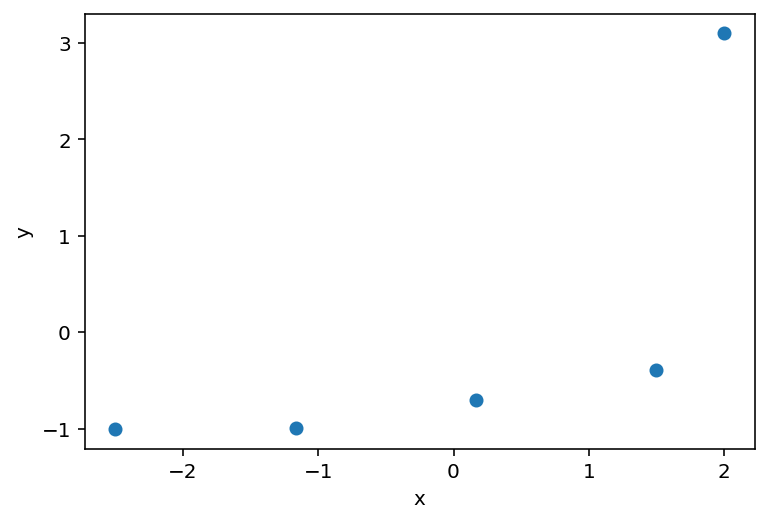

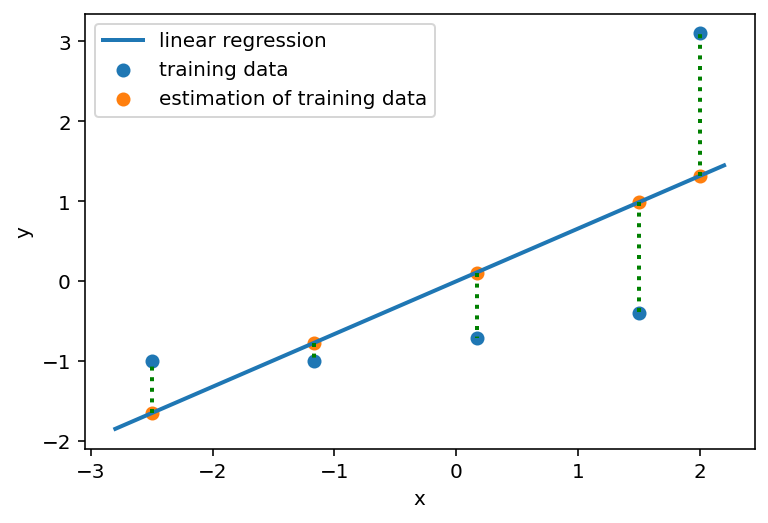

In [51]:
from scipy import stats

n = 4
s = 0.2
a = 0.1
b = 0
x = np.linspace(-2,2,n)
y = a*x + b + stats.norm.rvs(loc=0, scale=s, size=n, random_state=42)
x = np.hstack((x,2.5*np.ones(1)))
y = np.hstack((y,4*np.ones(1)))
mx = np.mean(x)
my = np.mean(y)
x-=mx # center data
y-=my # center targets
x = x.reshape(-1,1)
y = y.reshape(-1,1)
plt.figure()
plt.scatter(x,y)
_=plt.xlabel('x')
_=plt.ylabel('y')


LR = LinearRegression().fit(x.reshape(-1,1),y)
plt.figure()
plt.scatter(x,y,label=('training data'))
_=plt.xlabel('x')
_=plt.ylabel('y')
xg = np.linspace(-2.8,2.2,20).reshape(-1,1)
yg = LR.predict(xg)
plt.plot(xg,yg,label='linear regression',linewidth=2)
yhat = LR.predict(x)
plt.scatter(x,yhat,label='estimation of training data')
for ii, xi in enumerate(x):
  plt.plot([xi,xi],[yhat[ii],y[ii]], linestyle=':', linewidth=2, color='green')
_=plt.legend()



In [52]:
from sklearn.linear_model import Ridge

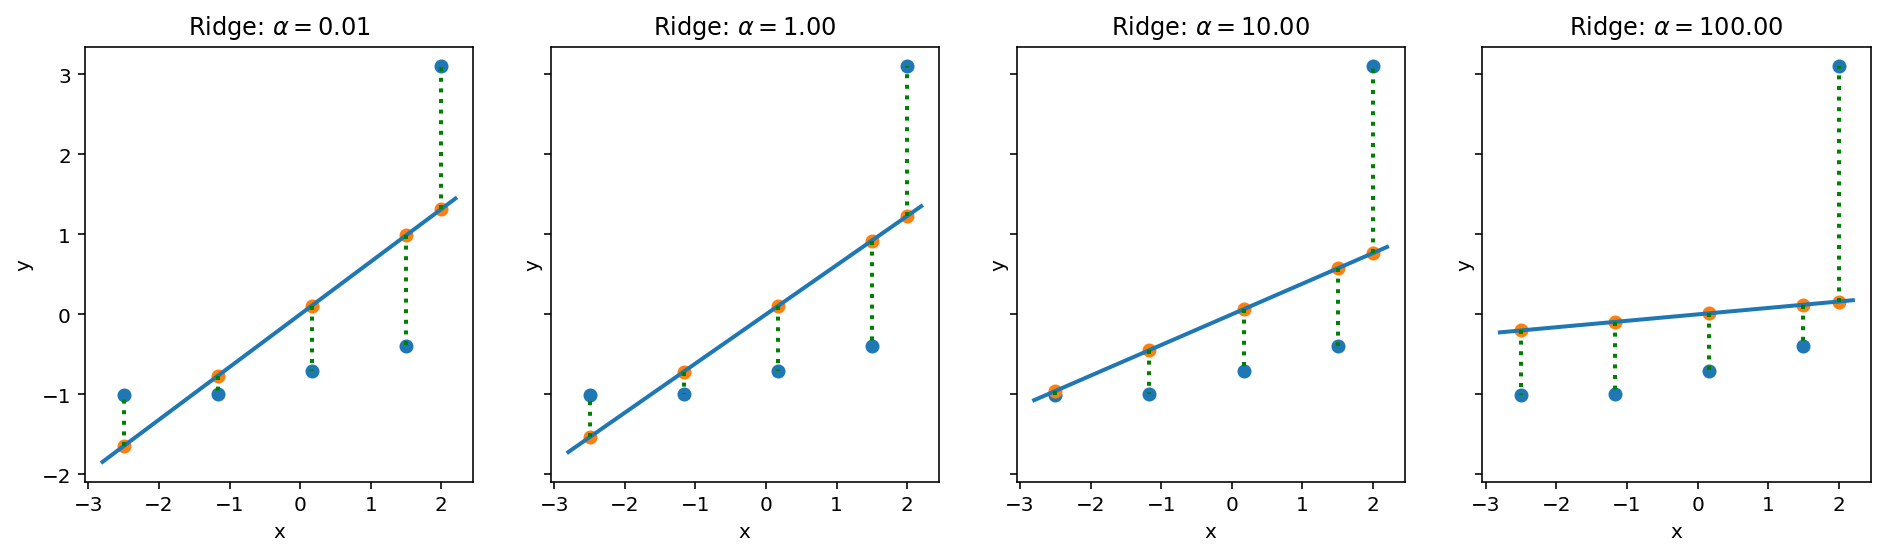

In [53]:
ff,aa = plt.subplots(1,4,sharex=True, sharey=True, figsize=(16,4))
v_la = [1e-2, 1, 10, 100]
for ii, la in enumerate(v_la):
    aa[ii].scatter(x,y,label=('training data'))
    _=aa[ii].set_xlabel('x')
    _=aa[ii].set_ylabel('y')
    
    RR = Ridge(alpha=la).fit(x.reshape(-1,1),y)
    yg = RR.predict(xg)
    aa[ii].plot(xg,yg,label='linear regression',linewidth=2)
    yhat = RR.predict(x)
    aa[ii].scatter(x,yhat,label='estimation of training data')
    aa[ii].set_title('Ridge: $\\alpha={0:.2f}$'.format(la))
    for jj, xj in enumerate(x):
        aa[ii].plot([xj,xj],[yhat[jj],y[jj]], linestyle=':', linewidth=2, color='green')

## LASSO Regularization 

Another regularization available in scikit learn is [LASSO](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html). The purpose of the LASSO regularization is to achieve sparsity in $\mathbf w$, that is, force non-relevant features to get a zero weight vector.

The optimization that leads to the LASSO linear regression is 

$$
\min_{w_0, \mathbf w} \frac{1}{N} \sum_{i=1}^N{(y_i-(w_0 + \mathbf w^\top \mathbf x))^2} + \alpha \sum_{j=1}^d|w_j| 
$$

where $d$ is the dimensionality of the data.

### Example with sparse $\mathbf w$ and correlated features

Generate a regression problem where the weight vector only depends on a subset of the columns and some columns are correlated.

In [54]:
n_train = 100
n_test = 500
dim = 5

# create data with 100 observations in dim dimensions
X_train = np.random.randn(n_train, dim)
X_test = np.random.randn(n_test, dim)

# create model
w = np.array([-1,1,.5,-.3,-.1])
sigma_noise = np.mean(np.std(X_test,0))/10

# generate targets
y_train = X_train.dot(w) + np.random.normal(size=n_train)*sigma_noise
y_test = X_test.dot(w) + np.random.normal(size=n_test)*sigma_noise

# create new columns correlated with the original dim columns

n_correl = 5
X_train_correl = np.zeros((n_train, n_correl))
X_test_correl = np.zeros((n_test, n_correl))
for nn in range(n_correl):
    # select number of components
    n_components = np.random.randint(2)
    which_columns = np.random.randint(0, dim, size=n_components)
    which_weights = np.random.normal(size=n_components)
    X_train_correl[:,nn] = X_train[:, which_columns].dot(which_weights) + np.random.normal(size=n_train)*sigma_noise
    X_test_correl[:,nn] = X_test[:, which_columns].dot(which_weights) + np.random.normal(size=n_test)*sigma_noise

XX_train = np.hstack((X_train, X_train_correl))
XX_test = np.hstack((X_test, X_test_correl))

print(XX_train.shape)


(100, 10)


In [55]:
w_true = np.zeros(XX_train.shape[1])
w_true[:dim] = w
print("True Weight Vector")
print(w_true)

True Weight Vector
[-1.   1.   0.5 -0.3 -0.1  0.   0.   0.   0.   0. ]


Ridge regression solution. The Ridge regularization does not force sparsity

In [56]:
RR = Ridge(alpha=1).fit(XX_train, y_train)
print("Ridge Regression accuracy")
print(np.round(RR.score(XX_test, y_test),3))
print("Ridge Regression weight vector")
print(np.round(RR.coef_,3))

Ridge Regression accuracy
0.996
Ridge Regression weight vector
[-0.996  0.995  0.496 -0.299 -0.096 -0.022 -0.063 -0.096 -0.049  0.07 ]


In [57]:
from sklearn.linear_model import Lasso

In [58]:
LS = Lasso(alpha=.01).fit(XX_train, y_train)
print("LASSO Regression accuracy")
print(np.round(LS.score(XX_test, y_test),3))
print("LASSO Regression weight vector")
print(np.round(LS.coef_,3))

LASSO Regression accuracy
0.995
LASSO Regression weight vector
[-0.994  0.996  0.488 -0.289 -0.085 -0.    -0.    -0.    -0.     0.   ]


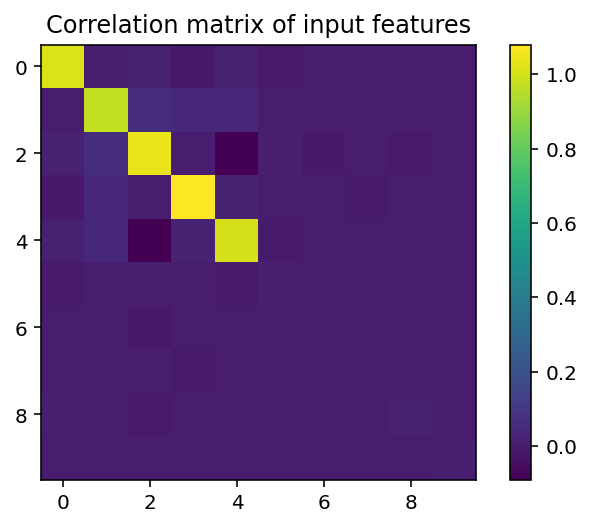

In [59]:
_=plt.imshow(XX_test.T.dot(XX_test)/XX_test.shape[0])
_ = plt.title('Correlation matrix of input features')
plt.colorbar()